# Deep learning on a public dataset

<h3>Implementation: Code</h3>

<h3>Section 1 : Data Pre-Processing , experimentation and initial sequential model execution <h3>

<p> In this section I will be loading the data , implementing various different model iterations which will be pre-processed uniquely for each network (denseNet , mobileNet and ResNet18). This section does not contain the final implementation but rather the thought process and proof of fututre reasoning in the project. This section will be longer then the final model evaluation and implementation but plays a key role in identifying and executing the best possible model. The section includes the implementation and evaluation of 24 sequential models which will be used to determine the 6 best performing models to be used in section 2  with the functional API </p>

In [158]:
# Import modules for used for all steps of implementation
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
import os
import random
import shutil
import pandas as pd
from PIL import Image
from tensorflow.keras.models import save_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import Input,Layer,Dropout, Conv2D,BatchNormalization, Activation, MaxPooling2D, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from keras.layers import MaxPool2D, Flatten
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score , precision_score, recall_score , f1_score
from sklearn.preprocessing import LabelEncoder

The following code ensures that we use the GPU of my computer to assist with computational execution of building the network.

In [8]:
# I wrote this code

# ensure GPU is in use for later processing
gpuDevice = tf.config.list_physical_devices('GPU')

if gpuDevice:
    details = tf.config.experimental.get_device_details(gpuDevice[0])
    print("GPU found and in use!")
else:
    print("GPU not found!")
    
# End of code I wrote

GPU found and in use!


The data path for both testing and training data is set so that we can acces the dataset:

In [9]:
trainDataPath = 'C:/Users/chaan/Desktop/Machine Learning final project/DATASET/TRAIN'
testDataPath = 'C:/Users/chaan/Desktop/Machine Learning final project/DATASET/TEST'

I use image data generator to process and apply data augmentation techniques to the data without creating new instances of data.Horizontal flip allows for interesting results difference which we will both investigate to show. Rescaling normalizes the images from [0,255] to [0,1] which assists with the loss weights of the network.

In [10]:
horizontalPreprocessDatagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True)

The below fuunction takes an image and sigma value which applies blur it was inspired from the following code https://stackoverflow.com/questions/66555567/applying-gaussian-blur-to-images-in-a-loop

In [11]:
def gaussianBlurImage(img , sigma = 1.0):
    return cv2.GaussianBlur(img, (0, 0), sigma)

In [12]:
gaussianBlurPreprocessDatagen = ImageDataGenerator(
    rescale=1./255,
    # the labda inline function is an inline function implementation of gaussian blur
    preprocessing_function=lambda x: gaussianBlurImage(x, sigma=0.8)
)

In [13]:
# we set data and labels as eempty arrays

data = []  
labels = []  

In [14]:
# the claslabels in the file are O and R for organic and recyclable

for classLabel in ['O', 'R']:
    
    # we join the train data path to the class labels and set to class path
    classPath = os.path.join(trainDataPath, classLabel)
    
    # loop through image files in train directory per label
    for imageFile in os.listdir(classPath):
        
        # enter another folder in class path and join to get image path
        imagePath = os.path.join(classPath, imageFile)
        
        # append image path and label to arrays
        data.append(imagePath)
        labels.append(classLabel)

In [15]:
# use train test split to split the data as 80 training and 20% testing data
# set data to random state as well

trainData, testData, trainLabels, testLabels = train_test_split(
    data,
    labels,
    test_size=0.2, 
    random_state=42  
)

To ensure we use optimal batch sizes, image widths, heights and we train the data for a sufficient amount of epochs. I will be implementing different ranges of these paramaters to optimize the models. The lower the image width and height and num of epochs the faster the model will build to completion , increasing the batch size will have the same effect but is computationally more expensive with memory usage. 

In [16]:
# Fastest paramaters :

fastBatchSize = 64
fastImageWidth = 128
fastImageHeight = 128
earlyNumEpochs = 15   # number of Epochs stays consistent

# Slowest Paramaters : 

slowBatchSize = 32
slowImageWidth = 224 
slowImageHeight = 224 
finalNumEpochs = 30

The below code loads the train and test data into memory , sets the batch size, image size of the data and instantiates the classes. The class mode is set to binary since we are aiming to predict 2 classes only (organic and recyclable). We set both fast and slower test data to compare the results of these paramaters. We will also create data which is shuffled and not shuffled. Lastly all data class modes are set to binary since the task we are implementing is binary cclassification of 2 labels.

In [17]:
# set test datagen to be normal imageDatagenerator of normalized fields

testDatagen = ImageDataGenerator(rescale=1./255)

# we use the faster variables to create a fast test generator to be used for validation on models using faster parameters
fastTestGenerator = testDatagen.flow_from_dataframe(
    pd.DataFrame({'filename': testData, 'class': testLabels}),
    x_col='filename',
    y_col='class',
    target_size=(fastImageWidth, fastImageHeight),
    batch_size=fastBatchSize,
    class_mode='binary',
    classes=['O', 'R'],
    shuffle=False  
)

Found 4513 validated image filenames belonging to 2 classes.


In [18]:
# we use the slower variables to create slow test generator for validating models using slow paramaters

slowTestGenerator = testDatagen.flow_from_dataframe(
    pd.DataFrame({'filename': testData, 'class': testLabels}),
    x_col='filename',
    y_col='class',
    target_size=(slowImageWidth, slowImageHeight),
    batch_size=slowBatchSize,
    class_mode='binary',
    classes=['O', 'R'],
    shuffle=False  
)

Found 4513 validated image filenames belonging to 2 classes.


# Horizontal Flip Data

The below code implements fast building data and applies horizontal flip to the data with and without shuffling

In [19]:
fastTrainDataShuffleHF = horizontalPreprocessDatagen.flow_from_dataframe(
    pd.DataFrame({'filename': trainData, 'class': trainLabels}),
    x_col='filename',
    y_col='class',
    target_size=(fastImageWidth, fastImageHeight),
    batch_size=fastBatchSize,
    class_mode='binary',
    classes=['O', 'R'],
    shuffle=True
)


Found 18051 validated image filenames belonging to 2 classes.


In [20]:
fastTrainDataHF = horizontalPreprocessDatagen.flow_from_dataframe(
    pd.DataFrame({'filename': trainData, 'class': trainLabels}),
    x_col='filename',
    y_col='class',
    target_size=(fastImageWidth, fastImageHeight),
    batch_size=fastBatchSize,
    class_mode='binary',
    classes=['O', 'R'],
    shuffle=False
)

Found 18051 validated image filenames belonging to 2 classes.


The below code implements slows building data and applies horizontal flip to the data with and without shuffling

In [21]:
slowTrainDataShuffleHF = horizontalPreprocessDatagen.flow_from_dataframe(
    pd.DataFrame({'filename': trainData, 'class': trainLabels}),
    x_col='filename',
    y_col='class',
    target_size=(slowImageWidth, slowImageHeight),
    batch_size=slowBatchSize,
    class_mode='binary',
    classes=['O', 'R'],
    shuffle=True
)


Found 18051 validated image filenames belonging to 2 classes.


In [22]:
slowTrainDataHF = horizontalPreprocessDatagen.flow_from_dataframe(
    pd.DataFrame({'filename': trainData, 'class': trainLabels}),
    x_col='filename',
    y_col='class',
    target_size=(slowImageWidth, slowImageHeight),
    batch_size=slowBatchSize,
    class_mode='binary',
    classes=['O', 'R'],
    shuffle=False
)

Found 18051 validated image filenames belonging to 2 classes.


# Guassian Blur Data

The below code implements fast building data and applies Gaussian blur to the data with and without shuffling

In [23]:
fastTrainDataShuffleBlur = gaussianBlurPreprocessDatagen.flow_from_dataframe(
    pd.DataFrame({'filename': trainData, 'class': trainLabels}),
    x_col='filename',
    y_col='class',
    target_size=(fastImageWidth, fastImageHeight),
    batch_size=fastBatchSize,
    class_mode='binary',
    classes=['O', 'R'],
    shuffle=True
)

Found 18051 validated image filenames belonging to 2 classes.


In [24]:
fastTrainDataBlur = gaussianBlurPreprocessDatagen.flow_from_dataframe(
    pd.DataFrame({'filename': trainData, 'class': trainLabels}),
    x_col='filename',
    y_col='class',
    target_size=(fastImageWidth, fastImageHeight),
    batch_size=fastBatchSize,
    class_mode='binary',
    classes=['O', 'R'],
    shuffle=False
)

Found 18051 validated image filenames belonging to 2 classes.


The below code implements slows building data and applies gaussian blur to the data with and without shuffling

In [25]:
slowTrainDataShuffleBlur = gaussianBlurPreprocessDatagen.flow_from_dataframe(
    pd.DataFrame({'filename': trainData, 'class': trainLabels}),
    x_col='filename',
    y_col='class',
    target_size=(slowImageWidth, slowImageHeight),
    batch_size=slowBatchSize,
    class_mode='binary',
    classes=['O', 'R'],
    shuffle=True
)


Found 18051 validated image filenames belonging to 2 classes.


In [26]:
slowTrainDataBlur = gaussianBlurPreprocessDatagen.flow_from_dataframe(
    pd.DataFrame({'filename': trainData, 'class': trainLabels}),
    x_col='filename',
    y_col='class',
    target_size=(slowImageWidth, slowImageHeight),
    batch_size=slowBatchSize,
    class_mode='binary',
    classes=['O', 'R'],
    shuffle=False
)


Found 18051 validated image filenames belonging to 2 classes.


<h1>Section 2 </h1>

In total there are 10 different data pre-processing types to be implemented on 3 models each , concluding in 24 models to be trained and evaluated. The implementation of these models are a large part of the project and if the summarized reults are desirable , please go to the end of this section.The following code will determine which of the above pre-processing steps heeds the best results to be used further in the project

<h2> Sequential Model Implementation </h2>

In [54]:
# we set an empty dictionary to push all sequential models into and to save later

modelDict = {}

The compiling and implementation of all models will be done using the adam optimizer and binary_crossentropy as loss function. This suits the binary classification task we are implementing. Furthermore all models will end with a Dense layer with size of 1 and activation in this layer will be sigmoid. This will help map values between 0 and 1 for binary classification

<h3>DenseNet</h3>

The below code initializes 2 densenet models , one with faster variables as paramaters and one with slower values as paramaters

In [31]:
denseNetFastModel = DenseNet121(
    input_shape=(fastImageWidth,fastImageHeight, 3),  # smaller image sizes
    include_top=False # use pre-trained model as feature extractor
)

In [32]:
denseNetSlowModel = DenseNet121(
    input_shape=(slowImageWidth,slowImageHeight, 3),  # larger image sizes
    include_top=False # use pre-trained model as feature extractor
)

DenseNet implementation of sequential model using fast variables , shuffle and gaussian blur

In [25]:
# define sequential model

denseNetFastModelGaussian = tf.keras.Sequential([
    denseNetFastModel,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid') # adding dense layer with sigmoid activation for binary classification
])

denseNetFastModelGaussian.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [26]:
denseNetFastModelGaussian.fit(
    fastTrainDataShuffleBlur,
    epochs=earlyNumEpochs,    # smaller amount of epochs
    validation_data=fastTestGenerator, # faster test data
    verbose = 1 # used to show validation values during training
)

Epoch 1/15
283/283 [==============================] - 64s 159ms/step - loss: 0.2947 - accuracy: 0.8880 - val_loss: 0.6831 - val_accuracy: 0.8241
Epoch 2/15
283/283 [==============================] - 41s 144ms/step - loss: 0.2366 - accuracy: 0.9074 - val_loss: 1.5758 - val_accuracy: 0.5218
Epoch 3/15
283/283 [==============================] - 41s 144ms/step - loss: 0.2039 - accuracy: 0.9211 - val_loss: 0.4021 - val_accuracy: 0.8232
Epoch 4/15
283/283 [==============================] - 41s 145ms/step - loss: 0.2094 - accuracy: 0.9180 - val_loss: 0.3833 - val_accuracy: 0.8376
Epoch 5/15
283/283 [==============================] - 41s 145ms/step - loss: 0.1682 - accuracy: 0.9355 - val_loss: 0.3415 - val_accuracy: 0.8447
Epoch 6/15
283/283 [==============================] - 41s 145ms/step - loss: 0.1513 - accuracy: 0.9427 - val_loss: 1.8066 - val_accuracy: 0.5967
Epoch 7/15
283/283 [==============================] - 41s 146ms/step - loss: 0.1496 - accuracy: 0.9434 - val_loss: 0.4253 - val_ac

In [123]:
# push trained model into model dictionary

modelDict['denseNetFastModelGaussian'] = denseNetFastModelGaussian

DenseNet implementation of sequential model using fast variables , gaussian blur and no shuffle

In [30]:
denseNetFastModelGaussianNoShuffle = tf.keras.Sequential([
    denseNetFastModel,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid') # adding dense layer with sigmoid activation for binary classification
])

denseNetFastModelGaussianNoShuffle.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [31]:
denseNetFastModelGaussianNoShuffle.fit(
    fastTrainDataBlur,
    epochs=earlyNumEpochs,  # smaller amount of epochs
    validation_data=fastTestGenerator, # faster test data
    verbose = 1 # used to show validation values during training
)

Epoch 1/15
283/283 [==============================] - 54s 148ms/step - loss: 0.1162 - accuracy: 0.9538 - val_loss: 0.8120 - val_accuracy: 0.6605
Epoch 2/15
283/283 [==============================] - 40s 142ms/step - loss: 0.0687 - accuracy: 0.9744 - val_loss: 0.4446 - val_accuracy: 0.8655
Epoch 3/15
283/283 [==============================] - 41s 143ms/step - loss: 0.0481 - accuracy: 0.9830 - val_loss: 0.5092 - val_accuracy: 0.8648
Epoch 4/15
283/283 [==============================] - 40s 143ms/step - loss: 0.0394 - accuracy: 0.9853 - val_loss: 0.5029 - val_accuracy: 0.8586
Epoch 5/15
283/283 [==============================] - 40s 143ms/step - loss: 0.0401 - accuracy: 0.9849 - val_loss: 0.4484 - val_accuracy: 0.8697
Epoch 6/15
283/283 [==============================] - 41s 143ms/step - loss: 0.0481 - accuracy: 0.9824 - val_loss: 0.4139 - val_accuracy: 0.8870
Epoch 7/15
283/283 [==============================] - 41s 143ms/step - loss: 0.0361 - accuracy: 0.9864 - val_loss: 0.3989 - val_ac

In [124]:
# push trained model into model dictionary

modelDict['denseNetFastModelGaussianNoShuffle'] = denseNetFastModelGaussianNoShuffle

DenseNet implementation of sequential model using slow variables , gaussian blur and no shuffle

In [34]:
denseNetSlowModelGaussian = tf.keras.Sequential([
    denseNetSlowModel,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])
denseNetSlowModelGaussian.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [35]:
denseNetSlowModelGaussian.fit(
    slowTrainDataBlur,
    epochs=earlyNumEpochs,    # smaller amount of epochs
    validation_data=slowTestGenerator, # slower test data
    verbose = 1 # used to show validation values during training
)

Epoch 1/15
565/565 [==============================] - 135s 213ms/step - loss: 0.3000 - accuracy: 0.8826 - val_loss: 0.4647 - val_accuracy: 0.8671
Epoch 2/15
565/565 [==============================] - 116s 206ms/step - loss: 0.2469 - accuracy: 0.9043 - val_loss: 0.5081 - val_accuracy: 0.7860
Epoch 3/15
565/565 [==============================] - 115s 203ms/step - loss: 0.2146 - accuracy: 0.9188 - val_loss: 0.3741 - val_accuracy: 0.8440
Epoch 4/15
565/565 [==============================] - 116s 206ms/step - loss: 0.1943 - accuracy: 0.9260 - val_loss: 0.2808 - val_accuracy: 0.8934
Epoch 5/15
565/565 [==============================] - 117s 207ms/step - loss: 0.1965 - accuracy: 0.9247 - val_loss: 0.3584 - val_accuracy: 0.8575
Epoch 6/15
565/565 [==============================] - 117s 206ms/step - loss: 0.1728 - accuracy: 0.9343 - val_loss: 0.3449 - val_accuracy: 0.8425
Epoch 7/15
565/565 [==============================] - 116s 205ms/step - loss: 0.1558 - accuracy: 0.9402 - val_loss: 0.2956 -

In [125]:
# push trained model into model dictionary

modelDict['denseNetSlowModelGaussian'] = denseNetSlowModelGaussian

DenseNet implementation of sequential model using slow variables , gaussian blur and shuffle

In [38]:
denseNetSlowModelGaussianShuffle = tf.keras.Sequential([
    denseNetSlowModel,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])
denseNetSlowModelGaussianShuffle.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [39]:
denseNetSlowModelGaussianShuffle.fit(
    slowTrainDataShuffleBlur,
    epochs=earlyNumEpochs,    # smaller amount of epochs
    validation_data=slowTestGenerator,  # slower test data
    verbose = 1  # used to show validation values during training
)

Epoch 1/15
565/565 [==============================] - 129s 209ms/step - loss: 0.1123 - accuracy: 0.9580 - val_loss: 0.2252 - val_accuracy: 0.9200
Epoch 2/15
565/565 [==============================] - 117s 206ms/step - loss: 0.0772 - accuracy: 0.9705 - val_loss: 0.2554 - val_accuracy: 0.9156
Epoch 3/15
565/565 [==============================] - 117s 207ms/step - loss: 0.0994 - accuracy: 0.9631 - val_loss: 0.2755 - val_accuracy: 0.9025
Epoch 4/15
565/565 [==============================] - 117s 207ms/step - loss: 0.0848 - accuracy: 0.9670 - val_loss: 0.2671 - val_accuracy: 0.9160
Epoch 5/15
565/565 [==============================] - 117s 207ms/step - loss: 0.0625 - accuracy: 0.9775 - val_loss: 0.3299 - val_accuracy: 0.8994
Epoch 6/15
565/565 [==============================] - 117s 207ms/step - loss: 0.0750 - accuracy: 0.9721 - val_loss: 0.2408 - val_accuracy: 0.9127
Epoch 7/15
565/565 [==============================] - 117s 207ms/step - loss: 0.0503 - accuracy: 0.9816 - val_loss: 0.2589 -

In [126]:
# push trained model into model dictionary

modelDict['denseNetSlowModelGaussianShuffle'] = denseNetSlowModelGaussianShuffle

<h4>DenseNet using Horizontal flip. </h4>

DenseNet implementation of sequenital model using faster variables and horizontal flip with shuffle

In [42]:
denseNetFastModelHFShuffle = tf.keras.Sequential([
    denseNetFastModel,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])

denseNetFastModelHFShuffle.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [43]:
denseNetFastModelHFShuffle.fit(
    fastTrainDataShuffleHF,
    epochs=earlyNumEpochs,
    validation_data=fastTestGenerator,
    verbose = 1
)

Epoch 1/15
283/283 [==============================] - 54s 151ms/step - loss: 0.1137 - accuracy: 0.9592 - val_loss: 0.2207 - val_accuracy: 0.9271
Epoch 2/15
283/283 [==============================] - 41s 145ms/step - loss: 0.0807 - accuracy: 0.9701 - val_loss: 0.2221 - val_accuracy: 0.9240
Epoch 3/15
283/283 [==============================] - 41s 146ms/step - loss: 0.0791 - accuracy: 0.9715 - val_loss: 0.2886 - val_accuracy: 0.8976
Epoch 4/15
283/283 [==============================] - 41s 146ms/step - loss: 0.0668 - accuracy: 0.9758 - val_loss: 0.2496 - val_accuracy: 0.9318
Epoch 5/15
283/283 [==============================] - 41s 146ms/step - loss: 0.0613 - accuracy: 0.9785 - val_loss: 0.2669 - val_accuracy: 0.9244
Epoch 6/15
283/283 [==============================] - 41s 146ms/step - loss: 0.0687 - accuracy: 0.9762 - val_loss: 0.4626 - val_accuracy: 0.7764
Epoch 7/15
283/283 [==============================] - 41s 146ms/step - loss: 0.0796 - accuracy: 0.9706 - val_loss: 0.2713 - val_ac

In [127]:
modelDict['denseNetFastModelHFShuffle'] = denseNetFastModelHFShuffle

DenseNet implementation of sequenital model using slower variables and horizontal flip with shuffle

In [45]:
denseNetSlowModelHFShuffle = tf.keras.Sequential([
    denseNetFastModel,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])

denseNetSlowModelHFShuffle.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [46]:
denseNetSlowModelHFShuffle.fit(
    slowTrainDataShuffleHF,
    epochs=earlyNumEpochs,
    validation_data=slowTestGenerator,
    verbose = 1
)

Epoch 1/15
565/565 [==============================] - 126s 204ms/step - loss: 0.1906 - accuracy: 0.9273 - val_loss: 0.1953 - val_accuracy: 0.9264
Epoch 2/15
565/565 [==============================] - 115s 203ms/step - loss: 0.1425 - accuracy: 0.9462 - val_loss: 0.2073 - val_accuracy: 0.9213
Epoch 3/15
565/565 [==============================] - 114s 203ms/step - loss: 0.1272 - accuracy: 0.9515 - val_loss: 0.1896 - val_accuracy: 0.9357
Epoch 4/15
565/565 [==============================] - 114s 202ms/step - loss: 0.1096 - accuracy: 0.9586 - val_loss: 0.2624 - val_accuracy: 0.9205
Epoch 5/15
565/565 [==============================] - 114s 202ms/step - loss: 0.1087 - accuracy: 0.9597 - val_loss: 0.2247 - val_accuracy: 0.9282
Epoch 6/15
565/565 [==============================] - 114s 202ms/step - loss: 0.1017 - accuracy: 0.9603 - val_loss: 0.2028 - val_accuracy: 0.9278
Epoch 7/15
565/565 [==============================] - 114s 202ms/step - loss: 0.0850 - accuracy: 0.9688 - val_loss: 0.2439 -

In [128]:
modelDict['denseNetSlowModelHFShuffle'] = denseNetSlowModelHFShuffle

DenseNet implementation of sequenital model using faster variables and horizontal flip with no shuffling

In [49]:
denseNetFastHF = tf.keras.Sequential([
    denseNetFastModel,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])

denseNetFastHF.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [50]:
denseNetFastHF.fit(
    fastTrainDataHF,
    epochs=earlyNumEpochs,
    validation_data=fastTestGenerator,
    verbose = 1
)

Epoch 1/15
283/283 [==============================] - 52s 148ms/step - loss: 0.1017 - accuracy: 0.9587 - val_loss: 0.2234 - val_accuracy: 0.9258
Epoch 2/15
283/283 [==============================] - 40s 141ms/step - loss: 0.0426 - accuracy: 0.9844 - val_loss: 0.2662 - val_accuracy: 0.9271
Epoch 3/15
283/283 [==============================] - 40s 142ms/step - loss: 0.0274 - accuracy: 0.9910 - val_loss: 0.2707 - val_accuracy: 0.9342
Epoch 4/15
283/283 [==============================] - 40s 142ms/step - loss: 0.0243 - accuracy: 0.9910 - val_loss: 0.3007 - val_accuracy: 0.9176
Epoch 5/15
283/283 [==============================] - 40s 142ms/step - loss: 0.0258 - accuracy: 0.9904 - val_loss: 0.3205 - val_accuracy: 0.9289
Epoch 6/15
283/283 [==============================] - 40s 143ms/step - loss: 0.0201 - accuracy: 0.9925 - val_loss: 0.3575 - val_accuracy: 0.9193
Epoch 7/15
283/283 [==============================] - 40s 142ms/step - loss: 0.0167 - accuracy: 0.9939 - val_loss: 0.3902 - val_ac

In [129]:
modelDict['denseNetFastHF'] = denseNetFastHF

DenseNet implementation of sequenital model using slow variables and horizontal flip with no shuffling

In [53]:
denseNetSlowModelHF = tf.keras.Sequential([
    denseNetSlowModel,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])

denseNetSlowModelHF.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [54]:
denseNetSlowModelHF.fit(
    slowTrainDataHF,
    epochs=earlyNumEpochs,
    validation_data=slowTestGenerator,
    verbose = 1
)

Epoch 1/15
565/565 [==============================] - 129s 204ms/step - loss: 0.1057 - accuracy: 0.9628 - val_loss: 0.2918 - val_accuracy: 0.9036
Epoch 2/15
565/565 [==============================] - 114s 202ms/step - loss: 0.0786 - accuracy: 0.9712 - val_loss: 0.2179 - val_accuracy: 0.9258
Epoch 3/15
565/565 [==============================] - 114s 202ms/step - loss: 0.0614 - accuracy: 0.9788 - val_loss: 0.2673 - val_accuracy: 0.9173
Epoch 4/15
565/565 [==============================] - 114s 202ms/step - loss: 0.0572 - accuracy: 0.9796 - val_loss: 0.2630 - val_accuracy: 0.9306
Epoch 5/15
565/565 [==============================] - 114s 202ms/step - loss: 0.0525 - accuracy: 0.9811 - val_loss: 0.2544 - val_accuracy: 0.9326
Epoch 6/15
565/565 [==============================] - 114s 202ms/step - loss: 0.0466 - accuracy: 0.9833 - val_loss: 0.3225 - val_accuracy: 0.9349
Epoch 7/15
565/565 [==============================] - 114s 202ms/step - loss: 0.0410 - accuracy: 0.9852 - val_loss: 0.3435 -

In [130]:
modelDict['denseNetSlowModelHF'] = denseNetSlowModelHF

<h2>MobileNet</h2>

We again se 2 mobileNetV2 built in tensorflow models to the different image parameters and then we do not include the top so that we implement feature exctraction

In [56]:
mobileNetFastModel = MobileNetV2(
    input_shape=(fastImageWidth, fastImageHeight, 3),
    include_top=False,
)

In [39]:
mobileNetSlowModel = MobileNetV2(
    input_shape=(slowImageWidth, slowImageHeight, 3),
    include_top=False,
)

MobileNet implementation of sequenital model using fast variables , gaussian blur and shuffling

In [59]:
mobileNetFastModelGaussian = tf.keras.Sequential([
    mobileNetFastModel,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])
mobileNetFastModelGaussian.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [60]:
mobileNetFastModelGaussian.fit(
    fastTrainDataShuffleBlur,
    epochs=earlyNumEpochs,
    validation_data=fastTestGenerator,
    verbose = 1
)

Epoch 1/15
283/283 [==============================] - 33s 99ms/step - loss: 0.2743 - accuracy: 0.8962 - val_loss: 0.7614 - val_accuracy: 0.7035
Epoch 2/15
283/283 [==============================] - 27s 94ms/step - loss: 0.1890 - accuracy: 0.9281 - val_loss: 0.8327 - val_accuracy: 0.6986
Epoch 3/15
283/283 [==============================] - 27s 93ms/step - loss: 0.1899 - accuracy: 0.9290 - val_loss: 2.3571 - val_accuracy: 0.4899
Epoch 4/15
283/283 [==============================] - 27s 94ms/step - loss: 0.1531 - accuracy: 0.9427 - val_loss: 0.8298 - val_accuracy: 0.7804
Epoch 5/15
283/283 [==============================] - 26s 93ms/step - loss: 0.1230 - accuracy: 0.9539 - val_loss: 3.1182 - val_accuracy: 0.4824
Epoch 6/15
283/283 [==============================] - 26s 93ms/step - loss: 0.1168 - accuracy: 0.9553 - val_loss: 2.1044 - val_accuracy: 0.6280
Epoch 7/15
283/283 [==============================] - 26s 93ms/step - loss: 0.1208 - accuracy: 0.9538 - val_loss: 3.9256 - val_accuracy:

In [131]:
modelDict['mobileNetFastModelGaussian'] = mobileNetFastModelGaussian

MobileNet implementation of sequenital model using fast variables , gaussian blur and no shuffling

In [63]:
mobileNetFastModelGaussianNoShuffle = tf.keras.Sequential([
    mobileNetFastModel,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])
mobileNetFastModelGaussianNoShuffle.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [64]:
mobileNetFastModelGaussianNoShuffle.fit(
    fastTrainDataBlur,
    epochs=earlyNumEpochs,
    validation_data=fastTestGenerator,
    verbose = 1
)

Epoch 1/15
283/283 [==============================] - 31s 94ms/step - loss: 0.0997 - accuracy: 0.9602 - val_loss: 2.1079 - val_accuracy: 0.8121
Epoch 2/15
283/283 [==============================] - 26s 92ms/step - loss: 0.0575 - accuracy: 0.9777 - val_loss: 3.1425 - val_accuracy: 0.6619
Epoch 3/15
283/283 [==============================] - 26s 93ms/step - loss: 0.0499 - accuracy: 0.9821 - val_loss: 5.1652 - val_accuracy: 0.5329
Epoch 4/15
283/283 [==============================] - 26s 91ms/step - loss: 0.0388 - accuracy: 0.9853 - val_loss: 2.3416 - val_accuracy: 0.6969
Epoch 5/15
283/283 [==============================] - 26s 92ms/step - loss: 0.0367 - accuracy: 0.9866 - val_loss: 4.2853 - val_accuracy: 0.5732
Epoch 6/15
283/283 [==============================] - 26s 92ms/step - loss: 0.0295 - accuracy: 0.9896 - val_loss: 1.6914 - val_accuracy: 0.8340
Epoch 7/15
283/283 [==============================] - 26s 92ms/step - loss: 0.0313 - accuracy: 0.9888 - val_loss: 1.6810 - val_accuracy:

In [132]:
modelDict['mobileNetFastModelGaussianNoShuffle'] = mobileNetFastModelGaussianNoShuffle

MobileNet implementation of sequenital model using slow variables , gaussian blur and shuffling.

In [68]:
mobileNetSlowGaussianBlurShuffle = tf.keras.Sequential([
    mobileNetSlowModel,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])
mobileNetSlowGaussianBlurShuffle.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [69]:
mobileNetSlowGaussianBlurShuffle.fit(
    slowTrainDataShuffleBlur,
    epochs=earlyNumEpochs,
    validation_data=slowTestGenerator,
    verbose = 1
)

Epoch 1/15
565/565 [==============================] - 85s 139ms/step - loss: 0.2600 - accuracy: 0.9012 - val_loss: 6.2510 - val_accuracy: 0.4392
Epoch 2/15
565/565 [==============================] - 77s 136ms/step - loss: 0.1994 - accuracy: 0.9262 - val_loss: 2.1594 - val_accuracy: 0.5048
Epoch 3/15
565/565 [==============================] - 77s 136ms/step - loss: 0.1751 - accuracy: 0.9332 - val_loss: 2.9595 - val_accuracy: 0.6811
Epoch 4/15
565/565 [==============================] - 77s 135ms/step - loss: 0.1637 - accuracy: 0.9376 - val_loss: 1.8758 - val_accuracy: 0.6284
Epoch 5/15
565/565 [==============================] - 77s 136ms/step - loss: 0.1499 - accuracy: 0.9434 - val_loss: 4.4522 - val_accuracy: 0.4591
Epoch 6/15
565/565 [==============================] - 78s 137ms/step - loss: 0.1451 - accuracy: 0.9449 - val_loss: 1.0003 - val_accuracy: 0.7713
Epoch 7/15
565/565 [==============================] - 77s 136ms/step - loss: 0.1307 - accuracy: 0.9493 - val_loss: 3.1512 - val_ac

In [133]:
modelDict['mobileNetSlowGaussianBlurShuffle'] = mobileNetSlowGaussianBlurShuffle

MobileNet implementation of sequenital model using slow variables, gaussian blur and no shuffling

In [72]:
mobileNetSlowGaussianBlur = tf.keras.Sequential([
    mobileNetSlowModel,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])
mobileNetSlowGaussianBlur.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [73]:
mobileNetSlowGaussianBlur.fit(
    slowTrainDataShuffleBlur,
    epochs=earlyNumEpochs,
    validation_data=slowTestGenerator,
    verbose = 1
)

Epoch 1/15
565/565 [==============================] - 83s 139ms/step - loss: 0.0687 - accuracy: 0.9754 - val_loss: 1.1771 - val_accuracy: 0.7992
Epoch 2/15
565/565 [==============================] - 78s 138ms/step - loss: 0.0930 - accuracy: 0.9654 - val_loss: 0.7835 - val_accuracy: 0.8316
Epoch 3/15
565/565 [==============================] - 77s 137ms/step - loss: 0.0568 - accuracy: 0.9797 - val_loss: 1.0665 - val_accuracy: 0.8247
Epoch 4/15
565/565 [==============================] - 78s 137ms/step - loss: 0.0601 - accuracy: 0.9779 - val_loss: 0.9800 - val_accuracy: 0.8274
Epoch 5/15
565/565 [==============================] - 78s 137ms/step - loss: 0.0429 - accuracy: 0.9842 - val_loss: 1.1066 - val_accuracy: 0.8130
Epoch 6/15
565/565 [==============================] - 78s 138ms/step - loss: 0.0580 - accuracy: 0.9799 - val_loss: 0.6023 - val_accuracy: 0.8779
Epoch 7/15
565/565 [==============================] - 78s 138ms/step - loss: 0.0346 - accuracy: 0.9871 - val_loss: 0.5242 - val_ac

In [134]:
modelDict['mobileNetSlowGaussianBlur'] = mobileNetSlowGaussianBlur

MobileNet implementation of sequenital model using fast variables , horizontal flip and shuffling

In [76]:
mobileNetFastModelHFShuffle = tf.keras.Sequential([
    mobileNetFastModel,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])

mobileNetFastModelHFShuffle.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [77]:
mobileNetFastModelHFShuffle.fit(
    fastTrainDataShuffleHF,
    epochs=earlyNumEpochs,
    validation_data=fastTestGenerator,
    verbose = 1
)

Epoch 1/15
283/283 [==============================] - 31s 95ms/step - loss: 0.1019 - accuracy: 0.9649 - val_loss: 2.6617 - val_accuracy: 0.6588
Epoch 2/15
283/283 [==============================] - 26s 91ms/step - loss: 0.0757 - accuracy: 0.9741 - val_loss: 0.8338 - val_accuracy: 0.7795
Epoch 3/15
283/283 [==============================] - 25s 90ms/step - loss: 0.0568 - accuracy: 0.9804 - val_loss: 0.8151 - val_accuracy: 0.8340
Epoch 4/15
283/283 [==============================] - 26s 91ms/step - loss: 0.0730 - accuracy: 0.9741 - val_loss: 0.7440 - val_accuracy: 0.8396
Epoch 5/15
283/283 [==============================] - 26s 91ms/step - loss: 0.0683 - accuracy: 0.9755 - val_loss: 1.3254 - val_accuracy: 0.7631
Epoch 6/15
283/283 [==============================] - 26s 91ms/step - loss: 0.0886 - accuracy: 0.9675 - val_loss: 0.7342 - val_accuracy: 0.8540
Epoch 7/15
283/283 [==============================] - 26s 91ms/step - loss: 0.0417 - accuracy: 0.9844 - val_loss: 0.5034 - val_accuracy:

In [135]:
modelDict['mobileNetFastModelHFShuffle'] = mobileNetFastModelHFShuffle

MobileNet implementation of sequenital model using fast variables , horizontal flip and no shuffling

In [80]:
mobileNetFastModelHF = tf.keras.Sequential([
    mobileNetFastModel,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])

mobileNetFastModelHF.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [81]:
mobileNetFastModelHF.fit(
    fastTrainDataHF,
    epochs=earlyNumEpochs,
    validation_data=fastTestGenerator,
    verbose = 1
)


Epoch 1/15
283/283 [==============================] - 31s 94ms/step - loss: 0.0483 - accuracy: 0.9852 - val_loss: 0.4247 - val_accuracy: 0.8990
Epoch 2/15
283/283 [==============================] - 26s 91ms/step - loss: 0.0306 - accuracy: 0.9878 - val_loss: 0.4450 - val_accuracy: 0.9160
Epoch 3/15
283/283 [==============================] - 26s 90ms/step - loss: 0.0271 - accuracy: 0.9903 - val_loss: 0.6456 - val_accuracy: 0.9027
Epoch 4/15
283/283 [==============================] - 26s 91ms/step - loss: 0.0246 - accuracy: 0.9910 - val_loss: 0.7364 - val_accuracy: 0.8945
Epoch 5/15
283/283 [==============================] - 26s 91ms/step - loss: 0.0208 - accuracy: 0.9927 - val_loss: 0.4327 - val_accuracy: 0.9200
Epoch 6/15
283/283 [==============================] - 26s 91ms/step - loss: 0.0185 - accuracy: 0.9932 - val_loss: 0.8933 - val_accuracy: 0.8642
Epoch 7/15
283/283 [==============================] - 26s 90ms/step - loss: 0.0243 - accuracy: 0.9917 - val_loss: 0.6153 - val_accuracy:

In [136]:
modelDict['mobileNetFastModelHF'] = mobileNetFastModelHF

MobileNet implementation of sequenital model using slow variables , horizontal flip and shuffling

In [84]:
mobileNetSlowHFShuffle = tf.keras.Sequential([
    mobileNetSlowModel,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])
mobileNetSlowHFShuffle.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [85]:
mobileNetSlowHFShuffle.fit(
    slowTrainDataShuffleHF,
    epochs=earlyNumEpochs,
    validation_data=slowTestGenerator,
    verbose = 1
)

Epoch 1/15
565/565 [==============================] - 81s 135ms/step - loss: 0.0928 - accuracy: 0.9680 - val_loss: 0.4452 - val_accuracy: 0.8815
Epoch 2/15
565/565 [==============================] - 76s 134ms/step - loss: 0.0729 - accuracy: 0.9746 - val_loss: 0.3046 - val_accuracy: 0.9127
Epoch 3/15
565/565 [==============================] - 75s 133ms/step - loss: 0.0590 - accuracy: 0.9796 - val_loss: 0.4063 - val_accuracy: 0.9047
Epoch 4/15
565/565 [==============================] - 76s 134ms/step - loss: 0.0533 - accuracy: 0.9812 - val_loss: 0.5303 - val_accuracy: 0.8706
Epoch 5/15
565/565 [==============================] - 75s 133ms/step - loss: 0.0536 - accuracy: 0.9814 - val_loss: 0.2798 - val_accuracy: 0.9264
Epoch 6/15
565/565 [==============================] - 76s 134ms/step - loss: 0.0600 - accuracy: 0.9778 - val_loss: 0.2899 - val_accuracy: 0.9209
Epoch 7/15
565/565 [==============================] - 77s 136ms/step - loss: 0.0602 - accuracy: 0.9787 - val_loss: 0.3060 - val_ac

In [137]:
modelDict['mobileNetSlowHFShuffle'] = mobileNetSlowHFShuffle

MobileNet implementation of sequenital model using slow variables , horizontal flip and no shuffling

In [89]:
mobileNetSlowHF = tf.keras.Sequential([
    mobileNetSlowModel,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])
mobileNetSlowHF.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [90]:
mobileNetSlowHF.fit(
    slowTrainDataHF ,
    epochs=earlyNumEpochs,
    validation_data=slowTestGenerator,
    verbose = 1
)

Epoch 1/15
565/565 [==============================] - 83s 135ms/step - loss: 0.0504 - accuracy: 0.9835 - val_loss: 0.3333 - val_accuracy: 0.9207
Epoch 2/15
565/565 [==============================] - 76s 135ms/step - loss: 0.0305 - accuracy: 0.9893 - val_loss: 0.4163 - val_accuracy: 0.9198
Epoch 3/15
565/565 [==============================] - 76s 135ms/step - loss: 0.0255 - accuracy: 0.9907 - val_loss: 0.3989 - val_accuracy: 0.9151
Epoch 4/15
565/565 [==============================] - 75s 134ms/step - loss: 0.0299 - accuracy: 0.9893 - val_loss: 0.4439 - val_accuracy: 0.9178
Epoch 5/15
565/565 [==============================] - 76s 135ms/step - loss: 0.0218 - accuracy: 0.9916 - val_loss: 0.4586 - val_accuracy: 0.9169
Epoch 6/15
565/565 [==============================] - 74s 131ms/step - loss: 0.0218 - accuracy: 0.9925 - val_loss: 0.4378 - val_accuracy: 0.9131
Epoch 7/15
565/565 [==============================] - 75s 133ms/step - loss: 0.0250 - accuracy: 0.9906 - val_loss: 0.3856 - val_ac

In [138]:
modelDict['mobileNetSlowHF'] = mobileNetSlowHF

<h2>ResNet18</h2>

The following code was found from : https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-resnet18-mnist.ipynb  
The code is not my own , there is no built in model for ResNet18 since it was depricated and replaced with later versions of ResNet18. The code is implemented using the functional API to add the 17 convolutional layers and 1 fully connected layer. I had to change the final output to a Dense layer of size 1 with sigmoid activation , this is to map the networks output between 0 and 1 for binary classification. 

In [41]:
# I did not write this code !

def ResnetBlock(inputs, channels, down_sample=False):
    strides = [2, 1] if down_sample else [1, 1]

    KERNEL_SIZE = (3, 3)
    INIT_SCHEME = "he_normal"

    x = Conv2D(channels, strides=strides[0], kernel_size=KERNEL_SIZE,
               padding="same", kernel_initializer=INIT_SCHEME)(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(channels, strides=strides[1], kernel_size=KERNEL_SIZE,
               padding="same", kernel_initializer=INIT_SCHEME)(x)
    x = BatchNormalization()(x)

    if down_sample:
        res = Conv2D(channels, (1, 1), strides=strides[0], kernel_initializer=INIT_SCHEME, padding="same")(inputs)
        res = BatchNormalization()(res)
    
    else:
        res = inputs

    # Ensure that the dimensions of x and res match
    if x.shape[-1] != res.shape[-1]:
        res = Conv2D(channels, (1, 1), strides=1, kernel_initializer=INIT_SCHEME, padding="same")(res)
        res = BatchNormalization()(res)

    x = Add()([x, res])
    x = Activation("relu")(x)
    
    return x

def ResNet18(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=2, padding="same", kernel_initializer="he_normal")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")(x)

    x = ResnetBlock(x, 64)
    x = ResnetBlock(x, 64)
    x = ResnetBlock(x, 128, down_sample=True)
    x = ResnetBlock(x, 128)
    x = ResnetBlock(x, 256, down_sample=True)
    x = ResnetBlock(x, 256)
    x = ResnetBlock(x, 512, down_sample=True)
    x = ResnetBlock(x, 512)

    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# End of code I did not write

In [42]:
# the resNet18 function takes an input shape and number of classes as input
# we use different paramaters depending on test data to validate with , there are 2 classes for it's binary classification

fastInputShape = (128, 128, 3) 
slowInputShape = (224, 224, 3) 
numClasses = 2

fastResNetModelBlurShuffle = ResNet18(fastInputShape, numClasses)
fastResNetModelHFShuffle = ResNet18(fastInputShape, numClasses)
fastResNetModelBlur = ResNet18(fastInputShape, numClasses)
fastResNetModelHF = ResNet18(fastInputShape, numClasses)

slowResNetModelBlurShuffle = ResNet18(slowInputShape, numClasses)
slowResNetModelHFShuffle  = ResNet18(slowInputShape, numClasses)
slowResNetModelBlur = ResNet18(slowInputShape, numClasses)
slowResNetModelHF = ResNet18(slowInputShape, numClasses)

All ResNet18 models are compiled with adam optimizer , binary crossentropy as loss function and accutacy as a metric to follow

In [94]:
fastResNetModelHFShuffle.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [95]:
fastResNetModelBlurShuffle.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [96]:
fastResNetModelBlur.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [97]:
fastResNetModelHF.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

All models are fitted with the relevant data , all models are then pushed into a dictionary to be saved and evaluated later.

In [98]:
fastResNetModelHF.fit(
    fastTrainDataHF,
    epochs=earlyNumEpochs,
    validation_data=fastTestGenerator,
    verbose = 1
)

Epoch 1/15
283/283 [==============================] - 22s 67ms/step - loss: 0.4472 - accuracy: 0.8181 - val_loss: 0.6277 - val_accuracy: 0.6734
Epoch 2/15
283/283 [==============================] - 18s 63ms/step - loss: 0.3629 - accuracy: 0.8490 - val_loss: 1.3317 - val_accuracy: 0.4901
Epoch 3/15
283/283 [==============================] - 18s 63ms/step - loss: 0.3400 - accuracy: 0.8595 - val_loss: 0.6024 - val_accuracy: 0.7190
Epoch 4/15
283/283 [==============================] - 18s 64ms/step - loss: 0.3186 - accuracy: 0.8684 - val_loss: 0.3609 - val_accuracy: 0.8469
Epoch 5/15
283/283 [==============================] - 18s 64ms/step - loss: 0.3076 - accuracy: 0.8760 - val_loss: 0.5299 - val_accuracy: 0.7518
Epoch 6/15
283/283 [==============================] - 18s 63ms/step - loss: 0.2967 - accuracy: 0.8793 - val_loss: 0.3590 - val_accuracy: 0.8418
Epoch 7/15
283/283 [==============================] - 18s 63ms/step - loss: 0.2806 - accuracy: 0.8871 - val_loss: 0.4409 - val_accuracy:

In [139]:
modelDict['fastResNetModelHF'] = fastResNetModelHF

In [100]:
fastResNetModelHFShuffle.fit(
    fastTrainDataShuffleHF,
    epochs=earlyNumEpochs,
    validation_data=fastTestGenerator,
    verbose = 1
)

Epoch 1/15
283/283 [==============================] - 21s 65ms/step - loss: 0.4470 - accuracy: 0.8130 - val_loss: 0.8384 - val_accuracy: 0.6333
Epoch 2/15
283/283 [==============================] - 18s 63ms/step - loss: 0.3744 - accuracy: 0.8412 - val_loss: 0.4409 - val_accuracy: 0.8079
Epoch 3/15
283/283 [==============================] - 18s 64ms/step - loss: 0.3466 - accuracy: 0.8542 - val_loss: 0.4977 - val_accuracy: 0.8183
Epoch 4/15
283/283 [==============================] - 18s 64ms/step - loss: 0.3350 - accuracy: 0.8590 - val_loss: 0.3630 - val_accuracy: 0.8651
Epoch 5/15
283/283 [==============================] - 18s 63ms/step - loss: 0.3372 - accuracy: 0.8596 - val_loss: 0.3608 - val_accuracy: 0.8396
Epoch 6/15
283/283 [==============================] - 18s 65ms/step - loss: 0.3128 - accuracy: 0.8732 - val_loss: 0.7209 - val_accuracy: 0.5947
Epoch 7/15
283/283 [==============================] - 19s 66ms/step - loss: 0.2961 - accuracy: 0.8792 - val_loss: 0.6169 - val_accuracy:

In [140]:
modelDict['fastResNetModelHFShuffle'] = fastResNetModelHFShuffle

In [102]:
fastResNetModelBlur.fit(
    fastTrainDataBlur,
    epochs=earlyNumEpochs,
    validation_data=fastTestGenerator,
    verbose = 1
)

Epoch 1/15
283/283 [==============================] - 23s 72ms/step - loss: 0.4678 - accuracy: 0.8078 - val_loss: 0.8645 - val_accuracy: 0.6849
Epoch 2/15
283/283 [==============================] - 20s 70ms/step - loss: 0.3732 - accuracy: 0.8442 - val_loss: 3.0735 - val_accuracy: 0.4997
Epoch 3/15
283/283 [==============================] - 20s 69ms/step - loss: 0.3436 - accuracy: 0.8588 - val_loss: 0.6760 - val_accuracy: 0.6807
Epoch 4/15
283/283 [==============================] - 19s 68ms/step - loss: 0.3245 - accuracy: 0.8662 - val_loss: 0.5354 - val_accuracy: 0.8331
Epoch 5/15
283/283 [==============================] - 19s 68ms/step - loss: 0.3090 - accuracy: 0.8715 - val_loss: 1.0491 - val_accuracy: 0.6229
Epoch 6/15
283/283 [==============================] - 20s 69ms/step - loss: 0.2925 - accuracy: 0.8813 - val_loss: 0.3446 - val_accuracy: 0.8595
Epoch 7/15
283/283 [==============================] - 19s 69ms/step - loss: 0.2728 - accuracy: 0.8876 - val_loss: 1.2319 - val_accuracy:

In [141]:
modelDict['fastResNetModelBlur'] = fastResNetModelBlur

In [104]:
fastResNetModelBlurShuffle.fit(
    fastTrainDataShuffleBlur,
    epochs=earlyNumEpochs,
    validation_data=fastTestGenerator,
    verbose = 1
)

Epoch 1/15
283/283 [==============================] - 22s 69ms/step - loss: 0.4660 - accuracy: 0.8028 - val_loss: 0.4553 - val_accuracy: 0.7984
Epoch 2/15
283/283 [==============================] - 20s 69ms/step - loss: 0.3736 - accuracy: 0.8449 - val_loss: 1.4440 - val_accuracy: 0.4972
Epoch 3/15
283/283 [==============================] - 20s 69ms/step - loss: 0.3489 - accuracy: 0.8537 - val_loss: 0.9491 - val_accuracy: 0.6479
Epoch 4/15
283/283 [==============================] - 19s 69ms/step - loss: 0.3377 - accuracy: 0.8614 - val_loss: 1.3030 - val_accuracy: 0.5322
Epoch 5/15
283/283 [==============================] - 19s 68ms/step - loss: 0.3400 - accuracy: 0.8590 - val_loss: 2.3185 - val_accuracy: 0.5493
Epoch 6/15
283/283 [==============================] - 20s 69ms/step - loss: 0.3078 - accuracy: 0.8722 - val_loss: 0.3745 - val_accuracy: 0.8453
Epoch 7/15
283/283 [==============================] - 19s 68ms/step - loss: 0.2914 - accuracy: 0.8822 - val_loss: 0.5383 - val_accuracy:

In [142]:
modelDict['fastResNetModelBlurShuffle'] = fastResNetModelBlurShuffle

ResNet models using slower variables are also all compiled using binary crossentropy as a loss function, adam as a optiomizer and follows the accuracy metric

In [106]:
slowResNetModelBlurShuffle.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [107]:
slowResNetModelBlur.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [108]:
slowResNetModelHF.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [109]:
slowResNetModelHFShuffle.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

We fit all models with relevant paramaters such as which data to use for training and validation. Wee then add the models to a dictionary to be saved and evaluated later.

In [110]:
slowResNetModelHF.fit(
    slowTrainDataHF,
    epochs=earlyNumEpochs,
    validation_data=slowTestGenerator,
    verbose = 1
)

Epoch 1/15
565/565 [==============================] - 42s 69ms/step - loss: 0.4487 - accuracy: 0.8111 - val_loss: 0.5182 - val_accuracy: 0.7961
Epoch 2/15
565/565 [==============================] - 39s 69ms/step - loss: 0.3765 - accuracy: 0.8447 - val_loss: 0.6376 - val_accuracy: 0.7299
Epoch 3/15
565/565 [==============================] - 39s 69ms/step - loss: 0.3531 - accuracy: 0.8530 - val_loss: 1.1743 - val_accuracy: 0.6302
Epoch 4/15
565/565 [==============================] - 38s 68ms/step - loss: 0.3313 - accuracy: 0.8649 - val_loss: 0.5543 - val_accuracy: 0.6831
Epoch 5/15
565/565 [==============================] - 38s 68ms/step - loss: 0.3149 - accuracy: 0.8724 - val_loss: 0.3897 - val_accuracy: 0.8225
Epoch 6/15
565/565 [==============================] - 38s 68ms/step - loss: 0.3005 - accuracy: 0.8810 - val_loss: 0.4732 - val_accuracy: 0.8110
Epoch 7/15
565/565 [==============================] - 38s 68ms/step - loss: 0.2893 - accuracy: 0.8847 - val_loss: 0.4811 - val_accuracy:

In [143]:
modelDict['slowResNetModelHF'] = slowResNetModelHF

In [112]:
slowResNetModelBlur.fit(
    slowTrainDataBlur,
    epochs=earlyNumEpochs,
    validation_data=slowTestGenerator,
    verbose = 1
)

Epoch 1/15
565/565 [==============================] - 41s 68ms/step - loss: 0.4509 - accuracy: 0.8124 - val_loss: 0.8886 - val_accuracy: 0.6803
Epoch 2/15
565/565 [==============================] - 38s 68ms/step - loss: 0.3763 - accuracy: 0.8402 - val_loss: 0.5032 - val_accuracy: 0.7910
Epoch 3/15
565/565 [==============================] - 39s 69ms/step - loss: 0.3523 - accuracy: 0.8523 - val_loss: 0.4455 - val_accuracy: 0.8006
Epoch 4/15
565/565 [==============================] - 39s 70ms/step - loss: 0.3401 - accuracy: 0.8613 - val_loss: 0.2951 - val_accuracy: 0.8768
Epoch 5/15
565/565 [==============================] - 39s 69ms/step - loss: 0.3122 - accuracy: 0.8745 - val_loss: 0.3066 - val_accuracy: 0.8746
Epoch 6/15
565/565 [==============================] - 39s 70ms/step - loss: 0.3000 - accuracy: 0.8803 - val_loss: 0.7734 - val_accuracy: 0.6419
Epoch 7/15
565/565 [==============================] - 39s 70ms/step - loss: 0.2876 - accuracy: 0.8836 - val_loss: 0.4716 - val_accuracy:

In [144]:
modelDict['slowResNetModelBlur'] = slowResNetModelBlur

In [114]:
slowResNetModelBlurShuffle.fit(
    slowTrainDataShuffleBlur,
    epochs=earlyNumEpochs,
    validation_data=slowTestGenerator,
    verbose = 1
)

Epoch 1/15
565/565 [==============================] - 41s 69ms/step - loss: 0.4637 - accuracy: 0.8021 - val_loss: 3.9161 - val_accuracy: 0.4806
Epoch 2/15
565/565 [==============================] - 38s 68ms/step - loss: 0.3882 - accuracy: 0.8340 - val_loss: 0.5272 - val_accuracy: 0.7574
Epoch 3/15
565/565 [==============================] - 39s 68ms/step - loss: 0.3567 - accuracy: 0.8495 - val_loss: 0.4988 - val_accuracy: 0.7365
Epoch 4/15
565/565 [==============================] - 39s 68ms/step - loss: 0.3471 - accuracy: 0.8552 - val_loss: 0.7308 - val_accuracy: 0.6339
Epoch 5/15
565/565 [==============================] - 38s 68ms/step - loss: 0.3338 - accuracy: 0.8602 - val_loss: 0.3554 - val_accuracy: 0.8504
Epoch 6/15
565/565 [==============================] - 39s 68ms/step - loss: 0.3204 - accuracy: 0.8670 - val_loss: 0.8181 - val_accuracy: 0.6729
Epoch 7/15
565/565 [==============================] - 39s 68ms/step - loss: 0.3107 - accuracy: 0.8730 - val_loss: 0.3624 - val_accuracy:

In [145]:
modelDict['slowResNetModelBlurShuffle'] = slowResNetModelBlurShuffle

In [116]:
slowResNetModelHFShuffle.fit(
    slowTrainDataShuffleHF,
    epochs=earlyNumEpochs,
    validation_data=slowTestGenerator,
    verbose = 1
)

Epoch 1/15
565/565 [==============================] - 42s 70ms/step - loss: 0.4667 - accuracy: 0.8016 - val_loss: 0.4447 - val_accuracy: 0.8278
Epoch 2/15
565/565 [==============================] - 39s 69ms/step - loss: 0.3781 - accuracy: 0.8424 - val_loss: 0.4986 - val_accuracy: 0.8090
Epoch 3/15
565/565 [==============================] - 39s 70ms/step - loss: 0.3496 - accuracy: 0.8552 - val_loss: 0.3563 - val_accuracy: 0.8617
Epoch 4/15
565/565 [==============================] - 39s 69ms/step - loss: 0.3354 - accuracy: 0.8619 - val_loss: 0.4987 - val_accuracy: 0.8323
Epoch 5/15
565/565 [==============================] - 39s 70ms/step - loss: 0.3180 - accuracy: 0.8691 - val_loss: 0.3722 - val_accuracy: 0.8482
Epoch 6/15
565/565 [==============================] - 39s 69ms/step - loss: 0.3036 - accuracy: 0.8747 - val_loss: 0.3842 - val_accuracy: 0.8438
Epoch 7/15
565/565 [==============================] - 39s 69ms/step - loss: 0.2933 - accuracy: 0.8821 - val_loss: 0.3396 - val_accuracy:

In [146]:
modelDict['slowResNetModelHFShuffle'] = slowResNetModelHFShuffle

<h2> Model saving and initial evaluation </h2>

For this part of the implementation we will be saving the sequential models to a file locally with their names , we will then evaluate all sequential models to determine which models will be used in the implementation of the functional API.

In [147]:
# set models file path
modelDictionaryFilePath = 'C:/Users/chaan/Desktop/Machine Learning final project/ModelDictionary'

In [153]:
# see if the directory already exists otherwise make them

if not os.path.exists(modelDictionaryFilePath):
    os.makedirs(modelDictionaryFilePath)

# Iterate through model dictionary and make the file names inside the folder the model names and save the models

for modelName, model in modelDict.items():
    filename = f'{modelName}.h5'
    modelPath = os.path.join(modelDictionaryFilePath, filename)
    save_model(model,modelPath)

C:\Users\chaan\anaconda3\envs\tensorFlowGPU\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


The following function takes 3 parameters , the dictionary of models , slow test data paramaters higher image resolution and faster test data. The function then continues to create a dataframe which will include all numerical evaluation metrics. We then continue to iterate through the dictionary and determine if the model was trained using faster paramaters or slower paramaters. Depending on which was implemented on the model , we create a report variable which is then set to the classification report with a tunable paramater (output_dict) set to true to create a dictionary. We then create an object containing all values of the dataframe and add it to the dataframe. A dataframe is then returned. The concat method and examples can be found here: https://pandas.pydata.org/docs/reference/api/pandas.concat.html 

In [180]:
def evaluateSequentialModels(modelDictionary , slowTestData , fastTestData):
    
    # set dataframe with desirec columns
    sequentialModelDataFrame = pd.DataFrame(columns=['Model Name','Accuracy','Precision','Recall','F1-Score'])
    
    # class names from the dataset
    classNames = ['O', 'R'] 
   
    # iterate through models dictionary
    for modelName , model in modelDictionary.items():
        
        # see if fast is in the model name
        if 'fast' in modelName.lower():
            
            # predict the specific model on fast test data
            predictions = model.predict(fastTestData)
            
            # since binary classification values larger then 0.5 are changed to 1
            predictedLabels = (predictions > 0.5).astype(int)

            # use classification report to output dictionary
            report = classification_report(fastTestData.classes, predictedLabels, target_names=classNames, output_dict=True)
            
            # create object from dictionary to append to dataframe
            modelDataFrameRow = {
                'Model Name' : modelName,
                'F1-Score': report['weighted avg']['f1-score'],
                'Accuracy': report['accuracy'],
                'Precision': report['weighted avg']['precision'],
                'Recall': report['weighted avg']['recall']
            }
            
            # adds the object along specific axis
            sequentialModelDataFrame = pd.concat([sequentialModelDataFrame, pd.DataFrame([modelDataFrameRow])])
         
        # see if slow is in the model name
        elif 'slow' in modelName.lower():
            
            # predict the specific model on slow test data
            predictions = model.predict(slowTestData)
            
            # since binary classification values larger then 0.5 are changed to 1
            predictedLabels = (predictions > 0.5).astype(int)

            # use classification report to output dictionary
            report = classification_report(slowTestData.classes, predictedLabels, target_names=classNames, output_dict=True)
            
            # create object from dictionary to append to dataframe
            modelDataFrameRow = {
                'Model Name' : modelName,
                'F1-Score': report['weighted avg']['f1-score'],
                'Accuracy': report['accuracy'],
                'Precision': report['weighted avg']['precision'],
                'Recall': report['weighted avg']['recall']
            }
            
            # adds the object along specific axis
            sequentialModelDataFrame = pd.concat([sequentialModelDataFrame, pd.DataFrame([modelDataFrameRow])])
            
            
    return sequentialModelDataFrame

In [182]:
evaluationData = evaluateSequentialModels(modelDict,slowTestGenerator,fastTestGenerator)

In [186]:
# sort evaluation dataframe to be descending on the f1-score of each model
evaluationData.sort_values(by= 'F1-Score', ascending = False)

,Model Name,Accuracy,Precision,Recall,F1-Score
0,denseNetSlowModelGaussian,0.937292,0.937296,0.937292,0.937294
0,denseNetSlowModelHF,0.935298,0.936052,0.935298,0.935422
0,denseNetFastModelGaussian,0.932861,0.932837,0.932861,0.932847
0,denseNetFastModelHFShuffle,0.931088,0.931064,0.931088,0.931074
0,denseNetSlowModelGaussianShuffle,0.928872,0.931086,0.928872,0.929095
0,denseNetSlowModelHFShuffle,0.927099,0.927167,0.927099,0.926948
0,denseNetFastModelGaussianNoShuffle,0.926656,0.927787,0.926656,0.926826
0,denseNetFastHF,0.926213,0.927014,0.926213,0.926356
0,mobileNetSlowGaussianBlurShuffle,0.913361,0.913863,0.913361,0.913485
0,mobileNetSlowGaussianBlur,0.912475,0.916558,0.912475,0.912811


As we can see above denseNet performs the best of all sequential models , mobileNet second and resNet18 last. 

<h2>Section 3 : Implementing functional API for selected best model configurations </h2>

Now that we have determined which pre-processing steps are best suited for which models , we will take the 2 best performing models of each model type. Meaning we will implement the functional API on 6 models in total. 

<h2> DenseNet</h2>

The best model pre-processing values for the denseNet Architecture was found using the higher image resolution of (224,224) , gaussian blur was used for one model and horizontal flip for the other. Therefore we will implement two models using the functional API and the train data generators we created to execute these models. Furthermore we will be training the models for 30 epochs instead of 15 for clearer graphing and loss detection. 

Unfortunately building the models using the larger image resolutions results in memory issues for my computer. Therefore we will use the best models generated with the smaller image resolution , even when performing slightly worse.

In [2]:
# smaller input shape

finalInputShape = (128,128,3)

In [3]:
# more epochs then previously

finalEpochs = 30

In [4]:
# dictionary to store functional API model implementations

functionalModelDict = {}

In [5]:
# DensenetslowmodelGaussian

In [27]:
denseNetInputLayer = Input(shape=finalInputShape)

In [29]:
# set a denseNet121 model with input layer of 128,128,3 shape
# include top to false to asllow for feature extractions

denseFunctionalModel = DenseNet121(
    input_shape = finalInputShape,
    include_top = False,
    input_tensor = denseNetInputLayer
)

In [30]:
# set a denseNet121 model with input layer of 128,128,3 shape
# here we use imagenet as weights , imagenet is a vast database of images and we can compare the inclusion of imagenet

denseFunctionalModelImageNetWeights = DenseNet121(
    input_shape = finalInputShape,
    include_top = False,
    input_tensor = denseNetInputLayer,
    weights='imagenet',
)

In [28]:
# the following function creates a dense model using the functional api with some custom selected layers
# the function takes a model as input

def createDenseModelFunctionAPI(model):
    
    # globalAvgPool used to replace fully connected layers in convolutional Neural Networks
    globalAvgPoolingLayer = GlobalAveragePooling2D()(model.output)

    # converts above layer to be processed by dense layers
    flattenLayer = Flatten()(globalAvgPoolingLayer)

    # dense layers help with feature extraction
    denseLayer1 = Dense(256, activation='relu')(flattenLayer)
    
    # Normalize layers 
    batchNorm1 = BatchNormalization()(denseLayer1)
    
    # remove random layer ouputs
    dropoutExecution1 = Dropout(0.5)(batchNorm1)
    
    # extract features
    denseLayer2 = Dense(128, activation='relu')(dropoutExecution1)
    
    # Normalize layers 
    batchNorm2 = BatchNormalization()(denseLayer2)
    
    # remove random layer ouputs
    dropoutExecution2 = Dropout(0.5)(batchNorm2)
    
    # extract features
    denseLayer3 = Dense(64, activation='relu')(dropoutExecution2)
    
    # Normalize layers 
    batchNorm3 = BatchNormalization()(denseLayer3)
    
    # remove random layer ouputs
    dropoutExecution3 = Dropout(0.5)(batchNorm3)

    # extract features
    denseLayer4 = Dense(32, activation='relu')(dropoutExecution3)
    
    # Normalize layers 
    batchNorm4 = BatchNormalization()(denseLayer4)
    
    # remove random layer ouputs
    dropoutExecution4 = Dropout(0.5)(batchNorm4)

    # use 1 unit dense layer with sigmoid activation to normalize values between 0 and 1 as outpuy
    outputLayer = Dense(1, activation='sigmoid')(dropoutExecution4)
    denseModel = tf.keras.Model(inputs=denseNetInputLayer, outputs=outputLayer)
    
    return denseModel

In [32]:
# set 2 models using above function

denseFunctionBlurModel = createDenseModelFunctionAPI(denseFunctionalModel)
denseFunctionHFModel = createDenseModelFunctionAPI(denseFunctionalModel)

In [33]:
denseFunctionBlurModel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [34]:
# compile models same as previouslty

denseFunctionBlurModel.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [35]:
denseFunctionHFModel.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [36]:
# fit models same as previously and push to functional dictionary

denseFunctionBlurModel.fit(
    fastTrainDataBlur,
    epochs=finalEpochs,
    validation_data=fastTestGenerator,
    batch_size=32,
    verbose = 1
)

Epoch 1/30
283/283 [==============================] - 69s 168ms/step - loss: 0.5722 - accuracy: 0.7454 - val_loss: 0.6289 - val_accuracy: 0.8179
Epoch 2/30
283/283 [==============================] - 41s 146ms/step - loss: 0.3307 - accuracy: 0.8758 - val_loss: 0.5125 - val_accuracy: 0.7955
Epoch 3/30
283/283 [==============================] - 41s 146ms/step - loss: 0.2729 - accuracy: 0.8980 - val_loss: 0.7092 - val_accuracy: 0.7082
Epoch 4/30
283/283 [==============================] - 41s 145ms/step - loss: 0.2483 - accuracy: 0.9108 - val_loss: 0.4180 - val_accuracy: 0.8148
Epoch 5/30
283/283 [==============================] - 41s 145ms/step - loss: 0.2273 - accuracy: 0.9161 - val_loss: 0.3446 - val_accuracy: 0.8473
Epoch 6/30
283/283 [==============================] - 41s 145ms/step - loss: 0.2003 - accuracy: 0.9247 - val_loss: 0.3152 - val_accuracy: 0.8799
Epoch 7/30
283/283 [==============================] - 41s 146ms/step - loss: 0.1912 - accuracy: 0.9289 - val_loss: 0.3449 - val_ac

In [80]:
functionalModelDict['denseFunctionBlurModel'] = denseFunctionBlurModel

In [37]:
denseFunctionHFModel.fit(
    fastTrainDataHF,
    epochs=finalEpochs,
    validation_data=fastTestGenerator,
    batch_size=32,
    verbose = 1
)

Epoch 1/30
283/283 [==============================] - 53s 151ms/step - loss: 0.2222 - accuracy: 0.9186 - val_loss: 0.2684 - val_accuracy: 0.9083
Epoch 2/30
283/283 [==============================] - 41s 145ms/step - loss: 0.1298 - accuracy: 0.9580 - val_loss: 0.2703 - val_accuracy: 0.9127
Epoch 3/30
283/283 [==============================] - 41s 145ms/step - loss: 0.1243 - accuracy: 0.9603 - val_loss: 0.2924 - val_accuracy: 0.9083
Epoch 4/30
283/283 [==============================] - 41s 145ms/step - loss: 0.1133 - accuracy: 0.9640 - val_loss: 0.3415 - val_accuracy: 0.8925
Epoch 5/30
283/283 [==============================] - 41s 146ms/step - loss: 0.1020 - accuracy: 0.9676 - val_loss: 0.2518 - val_accuracy: 0.9213
Epoch 6/30
283/283 [==============================] - 41s 146ms/step - loss: 0.0937 - accuracy: 0.9690 - val_loss: 0.2570 - val_accuracy: 0.9105
Epoch 7/30
283/283 [==============================] - 41s 146ms/step - loss: 0.0840 - accuracy: 0.9734 - val_loss: 0.3704 - val_ac

In [81]:
functionalModelDict['denseFunctionHFModel'] = denseFunctionHFModel

In [38]:
denseFunctionBlurModelImageNet = createDenseModelFunctionAPI(denseFunctionalModelImageNetWeights)
denseFunctionHFModelImageNet = createDenseModelFunctionAPI(denseFunctionalModelImageNetWeights)

In [39]:
denseFunctionBlurModelImageNet.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [40]:
denseFunctionHFModelImageNet.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [41]:
denseFunctionBlurModelImageNet.fit(
    fastTrainDataBlur,
    epochs=finalEpochs,
    validation_data=fastTestGenerator,
    batch_size=32,
    verbose = 1
)

Epoch 1/30
283/283 [==============================] - 54s 151ms/step - loss: 0.5912 - accuracy: 0.7150 - val_loss: 0.4987 - val_accuracy: 0.8252
Epoch 2/30
283/283 [==============================] - 41s 145ms/step - loss: 0.3560 - accuracy: 0.8621 - val_loss: 1.0886 - val_accuracy: 0.6047
Epoch 3/30
283/283 [==============================] - 41s 145ms/step - loss: 0.2913 - accuracy: 0.8911 - val_loss: 0.4279 - val_accuracy: 0.7979
Epoch 4/30
283/283 [==============================] - 41s 145ms/step - loss: 0.2568 - accuracy: 0.9046 - val_loss: 0.4948 - val_accuracy: 0.7509
Epoch 5/30
283/283 [==============================] - 41s 145ms/step - loss: 0.2291 - accuracy: 0.9162 - val_loss: 0.6598 - val_accuracy: 0.7363
Epoch 6/30
283/283 [==============================] - 41s 145ms/step - loss: 0.2120 - accuracy: 0.9250 - val_loss: 0.2573 - val_accuracy: 0.8954
Epoch 7/30
283/283 [==============================] - 41s 145ms/step - loss: 0.1935 - accuracy: 0.9310 - val_loss: 1.1536 - val_ac

In [82]:
functionalModelDict['denseFunctionBlurModelImageNet'] = denseFunctionBlurModelImageNet

In [42]:
denseFunctionHFModelImageNet.fit(
    fastTrainDataHF,
    epochs=finalEpochs,
    validation_data=fastTestGenerator,
    batch_size=32,
    verbose = 1
)

Epoch 1/30
283/283 [==============================] - 54s 151ms/step - loss: 0.2237 - accuracy: 0.9198 - val_loss: 0.2478 - val_accuracy: 0.9078
Epoch 2/30
283/283 [==============================] - 41s 145ms/step - loss: 0.1325 - accuracy: 0.9562 - val_loss: 0.3016 - val_accuracy: 0.9118
Epoch 3/30
283/283 [==============================] - 41s 145ms/step - loss: 0.1261 - accuracy: 0.9599 - val_loss: 0.2206 - val_accuracy: 0.9244
Epoch 4/30
283/283 [==============================] - 41s 145ms/step - loss: 0.1023 - accuracy: 0.9673 - val_loss: 0.2326 - val_accuracy: 0.9269
Epoch 5/30
283/283 [==============================] - 41s 145ms/step - loss: 0.0894 - accuracy: 0.9716 - val_loss: 0.2494 - val_accuracy: 0.9224
Epoch 6/30
283/283 [==============================] - 41s 145ms/step - loss: 0.0845 - accuracy: 0.9741 - val_loss: 0.2305 - val_accuracy: 0.9320
Epoch 7/30
283/283 [==============================] - 41s 145ms/step - loss: 0.0757 - accuracy: 0.9760 - val_loss: 0.2640 - val_ac

In [83]:
functionalModelDict['denseFunctionHFModelImageNet'] = denseFunctionHFModelImageNet

# MobileNet

MobileNet was unfortunately not very easy to implement the functional API since I kept running out of memory when trying to implement more complex functional API models. This could be due to the dataset being very large already or that the functional API could be computationally expensive when implementing complex values.

In [34]:
# set mobileNet model as feature extractor and smaller image input types

MobileNetFunctionModel = MobileNetV2(
    input_shape=finalInputShape,
    include_top=False,
)

In [35]:
# set other mobilenet model with imagenet weights to determine how much of an impact this has

MobileNetFunctionModelImagenetWeights = MobileNetV2(
    input_shape=finalInputShape,
    include_top=False,
    weights='imagenet'
)

In [36]:
# short function to implement mobileNet functional API 

def createMobileModelFunctionalAPI(model):
    
    # globalAvgPool used to replace fully connected layers in convolutional Neural Networks 
    globalAveragePoolingLayer = GlobalAveragePooling2D()(model.output)
    
    # normalize the data 
    batchNorm1 = BatchNormalization()(globalAveragePoolingLayer) 
    
    # converts above layer to be processed by dense layers
    flatten1 = Flatten()(batchNorm1) 
    
    # change output of model to be binary using dense network with sigmoid activation to map between 0 and 1
    outputLayer = Dense(1, activation='sigmoid')(globalAveragePoolingLayer)
    
    mobileModel = Model(inputs=model.input, outputs = outputLayer)

    return mobileModel

In [51]:
# set mobile models

mobileNetFunctionalModelHFShuffle = createMobileModelFunctionalAPI(MobileNetFunctionModel)
mobileNetFunctionalModelHF = createMobileModelFunctionalAPI(MobileNetFunctionModel)
mobileNetFunctionalModelHFSHuffleImageNet = createMobileModelFunctionalAPI(MobileNetFunctionModelImagenetWeights)
mobileNetFunctionalModelHFImageNet = createMobileModelFunctionalAPI(MobileNetFunctionModelImagenetWeights)

In [72]:
mobileNetFunctionalModelHFShuffle.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

We compile all models using binary crossentropy as loss function with adam optimizer.

In [64]:
mobileNetFunctionalModelHFShuffle.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [65]:
mobileNetFunctionalModelHF.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [66]:
mobileNetFunctionalModelHFSHuffleImageNet.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [67]:
mobileNetFunctionalModelHFImageNet.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

We fit all models with their matching data and add the models into dictionary to use for evaluation later.

In [68]:
mobileNetFunctionalModelHFShuffle.fit(
    fastTrainDataShuffleHF,
    epochs=finalEpochs,
    validation_data=fastTestGenerator,
    batch_size=32,
    verbose = 1
)

Epoch 1/30
283/283 [==============================] - 49s 128ms/step - loss: 0.2528 - accuracy: 0.9067 - val_loss: 2.6751 - val_accuracy: 0.5150
Epoch 2/30
283/283 [==============================] - 28s 98ms/step - loss: 0.1956 - accuracy: 0.9280 - val_loss: 1.3402 - val_accuracy: 0.6840
Epoch 3/30
283/283 [==============================] - 28s 97ms/step - loss: 0.1701 - accuracy: 0.9387 - val_loss: 1.4973 - val_accuracy: 0.6998
Epoch 4/30
283/283 [==============================] - 27s 96ms/step - loss: 0.1551 - accuracy: 0.9426 - val_loss: 1.3585 - val_accuracy: 0.7485
Epoch 5/30
283/283 [==============================] - 27s 97ms/step - loss: 0.1358 - accuracy: 0.9493 - val_loss: 2.2330 - val_accuracy: 0.6288
Epoch 6/30
283/283 [==============================] - 28s 97ms/step - loss: 0.1776 - accuracy: 0.9344 - val_loss: 2.5885 - val_accuracy: 0.6554
Epoch 7/30
283/283 [==============================] - 28s 97ms/step - loss: 0.1205 - accuracy: 0.9551 - val_loss: 0.9322 - val_accuracy

In [84]:
functionalModelDict['mobileNetFunctionalModelHFShuffle'] = mobileNetFunctionalModelHFShuffle

In [69]:
mobileNetFunctionalModelHF.fit(
    fastTrainDataHF,
    epochs=finalEpochs,
    validation_data=fastTestGenerator,
    batch_size=32,
    verbose = 1
)

Epoch 1/30
283/283 [==============================] - 32s 99ms/step - loss: 0.0695 - accuracy: 0.9749 - val_loss: 1.0899 - val_accuracy: 0.8733
Epoch 2/30
283/283 [==============================] - 27s 97ms/step - loss: 0.0446 - accuracy: 0.9833 - val_loss: 1.1406 - val_accuracy: 0.8764
Epoch 3/30
283/283 [==============================] - 27s 97ms/step - loss: 0.0418 - accuracy: 0.9835 - val_loss: 0.7035 - val_accuracy: 0.8945
Epoch 4/30
283/283 [==============================] - 27s 96ms/step - loss: 0.0361 - accuracy: 0.9871 - val_loss: 1.8631 - val_accuracy: 0.8068
Epoch 5/30
283/283 [==============================] - 27s 96ms/step - loss: 0.0348 - accuracy: 0.9875 - val_loss: 2.1773 - val_accuracy: 0.7749
Epoch 6/30
283/283 [==============================] - 27s 97ms/step - loss: 0.0319 - accuracy: 0.9895 - val_loss: 0.7628 - val_accuracy: 0.9018
Epoch 7/30
283/283 [==============================] - 27s 97ms/step - loss: 0.0304 - accuracy: 0.9891 - val_loss: 0.5052 - val_accuracy:

In [86]:
functionalModelDict['mobileNetFunctionalModelHF'] = mobileNetFunctionalModelHF

In [70]:
mobileNetFunctionalModelHFSHuffleImageNet.fit(
    fastTrainDataShuffleHF,
    epochs=finalEpochs,
    validation_data=fastTestGenerator,
    batch_size=32,
    verbose = 1
)

Epoch 1/30
283/283 [==============================] - 33s 101ms/step - loss: 0.2572 - accuracy: 0.9036 - val_loss: 3.3974 - val_accuracy: 0.5723
Epoch 2/30
283/283 [==============================] - 27s 97ms/step - loss: 0.1856 - accuracy: 0.9286 - val_loss: 2.1909 - val_accuracy: 0.6825
Epoch 3/30
283/283 [==============================] - 28s 98ms/step - loss: 0.1515 - accuracy: 0.9432 - val_loss: 3.5428 - val_accuracy: 0.5892
Epoch 4/30
283/283 [==============================] - 28s 98ms/step - loss: 0.1399 - accuracy: 0.9468 - val_loss: 1.6834 - val_accuracy: 0.7616
Epoch 5/30
283/283 [==============================] - 28s 98ms/step - loss: 0.1284 - accuracy: 0.9511 - val_loss: 3.1332 - val_accuracy: 0.5699
Epoch 6/30
283/283 [==============================] - 28s 97ms/step - loss: 0.1115 - accuracy: 0.9587 - val_loss: 2.8044 - val_accuracy: 0.6776
Epoch 7/30
283/283 [==============================] - 28s 98ms/step - loss: 0.1067 - accuracy: 0.9585 - val_loss: 2.6986 - val_accuracy

In [85]:
functionalModelDict['mobileNetFunctionalModelHFSHuffleImageNet'] = mobileNetFunctionalModelHFSHuffleImageNet

In [71]:
mobileNetFunctionalModelHFImageNet.fit(
    fastTrainDataHF,
    epochs=finalEpochs,
    validation_data=fastTestGenerator,
    batch_size=32,
    verbose = 1
)

Epoch 1/30
283/283 [==============================] - 34s 100ms/step - loss: 0.0651 - accuracy: 0.9773 - val_loss: 0.5712 - val_accuracy: 0.9207
Epoch 2/30
283/283 [==============================] - 28s 98ms/step - loss: 0.0423 - accuracy: 0.9857 - val_loss: 0.5971 - val_accuracy: 0.9098
Epoch 3/30
283/283 [==============================] - 28s 97ms/step - loss: 0.0412 - accuracy: 0.9858 - val_loss: 0.6409 - val_accuracy: 0.8992
Epoch 4/30
283/283 [==============================] - 28s 98ms/step - loss: 0.0316 - accuracy: 0.9890 - val_loss: 0.6243 - val_accuracy: 0.9089
Epoch 5/30
283/283 [==============================] - 28s 99ms/step - loss: 0.0354 - accuracy: 0.9875 - val_loss: 0.7089 - val_accuracy: 0.9076
Epoch 6/30
283/283 [==============================] - 28s 99ms/step - loss: 0.0268 - accuracy: 0.9905 - val_loss: 0.9322 - val_accuracy: 0.8684
Epoch 7/30
283/283 [==============================] - 28s 98ms/step - loss: 0.0267 - accuracy: 0.9900 - val_loss: 0.9555 - val_accuracy

In [87]:
functionalModelDict['mobileNetFunctionalModelHFImageNet'] = mobileNetFunctionalModelHFImageNet

# ResNet18

The below function implements a custom layer to be added to the ResNet18 model, Even though this is a short implementation it will be implemented 8 times in the function.

In [48]:
def customLayerFunc(layer):
    
    # add a convolution layer to resnet18 model
    convolutionalLayer = Conv2D(64, (3, 3), padding="same", activation="relu")(layer)
    
    # normalize the data
    batchNorm1 = BatchNormalization()(convolutionalLayer)
    
    # remove random outputs from layers
    dropout1 = Dropout(0.5)(batchNorm1)
     
    # add dense layer inside custom layer function
    dense1 = Dense(32, activation='relu')(dropout1)

    return dense1

The following code is similar to the initial implementation of the ResNet18 model , which was implemented using the functional API, I did however add a custom layer with some basic functionality, adding more complex functionality leads to memory leakadge. 

In [49]:
# I did not write this code , referenced earlier

def ResnetBlock(inputs, channels, down_sample=False):
    strides = [2, 1] if down_sample else [1, 1]

    KERNEL_SIZE = (3, 3)
    INIT_SCHEME = "he_normal"

    x = Conv2D(channels, strides=strides[0], kernel_size=KERNEL_SIZE,
               padding="same", kernel_initializer=INIT_SCHEME)(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(channels, strides=strides[1], kernel_size=KERNEL_SIZE,
               padding="same", kernel_initializer=INIT_SCHEME)(x)
    x = BatchNormalization()(x)

    if down_sample:
        res = Conv2D(channels, (1, 1), strides=strides[0], kernel_initializer=INIT_SCHEME, padding="same")(inputs)
        res = BatchNormalization()(res)
    
    else:
        res = inputs

    if x.shape[-1] != res.shape[-1]:
        res = Conv2D(channels, (1, 1), strides=1, kernel_initializer=INIT_SCHEME, padding="same")(res)
        res = BatchNormalization()(res)

    x = Add()([x, res])
    x = Activation("relu")(x)
    
    # my custom layer I wrote this one line of code
    x = customLayerFunc(x)
    
    return x

def ResNet18(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=2, padding="same", kernel_initializer="he_normal")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")(x)

    x = ResnetBlock(x, 64)
    x = ResnetBlock(x, 64)
    x = ResnetBlock(x, 128, down_sample=True)
    x = ResnetBlock(x, 128)
    x = ResnetBlock(x, 256, down_sample=True)
    x = ResnetBlock(x, 256)
    x = ResnetBlock(x, 512, down_sample=True)
    x = ResnetBlock(x, 512)

    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# end of code I did not write

In [55]:
# resnet model performs fine with larger input shape

inputShape = (224, 224, 3)
numClasses = 2

In [56]:
# set resNet models to be used

resNetModelFunctionalHF = ResNet18(inputShape, numClasses)
resNetModelFunctionalBlurShuffle = ResNet18(inputShape, numClasses)

In [73]:
resNetModelFunctionalHF.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization_24[0][0]     
___________________________________________________________________________________________

In [58]:
resNetModelFunctionalHF.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [75]:
resNetModelFunctionalBlurShuffle.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [60]:
resNetModelFunctionalHF.fit(
    fastTrainDataHF,
    epochs=finalEpochs,
    validation_data=fastTestGenerator,
    batch_size=64,
    verbose = 1
)

Epoch 1/30
283/283 [==============================] - 26s 73ms/step - loss: 0.5281 - accuracy: 0.7263 - val_loss: 1.8018 - val_accuracy: 0.7917
Epoch 2/30
283/283 [==============================] - 19s 68ms/step - loss: 0.3941 - accuracy: 0.8312 - val_loss: 0.8575 - val_accuracy: 0.7975
Epoch 3/30
283/283 [==============================] - 19s 68ms/step - loss: 0.3618 - accuracy: 0.8501 - val_loss: 0.5232 - val_accuracy: 0.8365
Epoch 4/30
283/283 [==============================] - 19s 68ms/step - loss: 0.3488 - accuracy: 0.8569 - val_loss: 0.4315 - val_accuracy: 0.8358
Epoch 5/30
283/283 [==============================] - 19s 68ms/step - loss: 0.3390 - accuracy: 0.8597 - val_loss: 0.7390 - val_accuracy: 0.8309
Epoch 6/30
283/283 [==============================] - 19s 68ms/step - loss: 0.3236 - accuracy: 0.8685 - val_loss: 0.3377 - val_accuracy: 0.8784
Epoch 7/30
283/283 [==============================] - 19s 68ms/step - loss: 0.3192 - accuracy: 0.8685 - val_loss: 0.6152 - val_accuracy:

In [88]:
functionalModelDict['resNetModelFunctionalHF'] = resNetModelFunctionalHF

In [74]:
resNetModelFunctionalBlurShuffle.fit(
    slowTrainDataBlur,
    epochs=finalEpochs,
    validation_data=slowTestGenerator,
    batch_size=64,
    verbose = 1
)

Epoch 1/30
565/565 [==============================] - 200s 354ms/step - loss: 0.1574 - accuracy: 0.9380 - val_loss: 0.6035 - val_accuracy: 0.7862
Epoch 2/30
565/565 [==============================] - 198s 350ms/step - loss: 0.1521 - accuracy: 0.9401 - val_loss: 1.0753 - val_accuracy: 0.6224
Epoch 3/30
565/565 [==============================] - 198s 350ms/step - loss: 0.1522 - accuracy: 0.9418 - val_loss: 0.7602 - val_accuracy: 0.7684
Epoch 4/30
565/565 [==============================] - 197s 349ms/step - loss: 0.1504 - accuracy: 0.9439 - val_loss: 0.6975 - val_accuracy: 0.7961
Epoch 5/30
565/565 [==============================] - 192s 340ms/step - loss: 0.1446 - accuracy: 0.9448 - val_loss: 0.8399 - val_accuracy: 0.7279
Epoch 6/30
565/565 [==============================] - 175s 309ms/step - loss: 0.1409 - accuracy: 0.9454 - val_loss: 0.7264 - val_accuracy: 0.8021
Epoch 7/30
565/565 [==============================] - 174s 309ms/step - loss: 0.1301 - accuracy: 0.9505 - val_loss: 0.5591 -

In [89]:
functionalModelDict['resNetModelFunctionalBlurShuffleSlow'] = resNetModelFunctionalBlurShuffle

In [31]:
functionalModelDictionaryFilePath = 'C:/Users/chaan/Desktop/Machine Learning final project/functionalModels'

In [92]:

# check if file path exists , otherwise make the new directory
if not os.path.exists(functionalModelDictionaryFilePath):
    os.makedirs(functionalModelDictionaryFilePath)

# loop through the dictionary items to get the name and model , subsequently create files containg the models and save the models
for modelName, model in functionalModelDict.items():
    filename = f'{modelName}.h5'
    modelPath = os.path.join(functionalModelDictionaryFilePath, filename)
    save_model(model,modelPath)

C:\Users\chaan\anaconda3\envs\tensorFlowGPU\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [34]:
# The following function will load models out of a given path paramater to 

def loadModelsAsDict(path):
    
    # set dict as empty dict to save models with
    loadedModelDict = {}
    
    # get the directory of saved models file path
    models = os.listdir(path)
    
    # loop through all models
    for modelName in models:
        
        # check if the file type matches an h5 file which is a model in tensorflow
        if modelName.endswith('.h5'):
            
            # get the name of the model file
            modelDictName = os.path.splitext(modelName)[0]
            
            # get the model path of current model in loop
            modelDictPath = os.path.join(path,modelName)
            
            # load the model with keras load_model method
            loadedModel = tf.keras.models.load_model(modelDictPath)
            
            # set the dictionary name equal to the current model in the loop
            loadedModelDict[modelDictName] = loadedModel
            
    return loadedModelDict

In [35]:
functionalModels = loadModelsAsDict(functionalModelDictionaryFilePath)

In [36]:
functionalModels

{'denseFunctionBlurModel': <keras.engine.functional.Functional at 0x216685be610>,
 'denseFunctionBlurModelImageNet': <keras.engine.functional.Functional at 0x21667809f10>,
 'denseFunctionHFModel': <keras.engine.functional.Functional at 0x2166ac4a400>,
 'denseFunctionHFModelImageNet': <keras.engine.functional.Functional at 0x2166b869790>,
 'mobileNetFunctionalModelHF': <keras.engine.functional.Functional at 0x2166bf81640>,
 'mobileNetFunctionalModelHFImageNet': <keras.engine.functional.Functional at 0x2166d61bfa0>,
 'mobileNetFunctionalModelHFShuffle': <keras.engine.functional.Functional at 0x2166b29c4f0>,
 'mobileNetFunctionalModelHFSHuffleImageNet': <keras.engine.functional.Functional at 0x2166dcb98b0>,
 'resNetModelFunctionalBlurShuffle': <keras.engine.functional.Functional at 0x2166e38f850>,
 'resNetModelFunctionalHF': <keras.engine.functional.Functional at 0x2166e5d2130>}

In [68]:
# the following function takes a dictionary of models , slow test data and faster test data as parameters
# the function creates a pandas dataframe of all the functional API models built , evaluates the models and predicts

def evaluateFunctionalModels(modelDictionary , slowTestData , fastTestData):
    
    # set a dataframe with columns of evaluation and model name
    functionalModelDataFrame = pd.DataFrame(columns=['Model Name','Accuracy','Precision','Recall','F1-Score'])
    
    # class names are data labels 
    classNames = ['O', 'R'] 
   
    # iterate through functional model dictionary
    for modelName , model in modelDictionary.items():
        
        # we look for the string slow in models names (there is 1 slow functional model)
        if 'slow' in modelName.lower():
            
            # predict on test data of slower models
            predictions = model.predict(slowTestData)
            
            # used to convert values larger then 0.5 to 1 
            predictedLabels = (predictions > 0.5).astype(int)

            # use classification report to output dictionary of evaluation metrics
            report = classification_report(slowTestData.classes, predictedLabels, target_names=classNames, output_dict=True)
            
            
            # create object to add to dataframe 
            modelDataFrameRow = {
                'Model Name' : modelName,
                'F1-Score': report['weighted avg']['f1-score'],
                'Accuracy': report['accuracy'],
                'Precision': report['weighted avg']['precision'],
                'Recall': report['weighted avg']['recall']
            }
            
            # merge object to dataframe on axis
            functionalModelDataFrame = pd.concat([functionalModelDataFrame, pd.DataFrame([modelDataFrameRow])])
            
        else:
            
            # we use the fast data model for all other models
            predictions = model.predict(fastTestData)
            
            # set predicted labels as 1 if larger then 0.5 for binary classification
            predictedLabels = (predictions > 0.5).astype(int)

            # use classification report to ouput dictionary values of evaluation metrics
            report = classification_report(fastTestData.classes, predictedLabels, target_names=classNames, output_dict=True)
            
            # set object of dataframe row values
            modelDataFrameRow = {
                'Model Name' : modelName,
                'F1-Score': report['weighted avg']['f1-score'],
                'Accuracy': report['accuracy'],
                'Precision': report['weighted avg']['precision'],
                'Recall': report['weighted avg']['recall']
            }
            
            # merge values of object into dataframe on axis
            functionalModelDataFrame = pd.concat([functionalModelDataFrame, pd.DataFrame([modelDataFrameRow])])
            
    return functionalModelDataFrame


In [51]:
functionalEvaluationDataframe = evaluateFunctionalModels(functionalModels,slowTestGenerator,fastTestGenerator)

In [52]:
# we evaluate the functional API models performances
functionalEvaluationDataframe.sort_values(by= 'F1-Score', ascending = False)

,Model Name,Accuracy,Precision,Recall,F1-Score
0,mobileNetFunctionalModelHFSHuffleImageNet,0.924219,0.924943,0.924219,0.924357
0,mobileNetFunctionalModelHFImageNet,0.923111,0.924642,0.923111,0.923315
0,denseFunctionHFModelImageNet,0.922889,0.924836,0.922889,0.923117
0,denseFunctionHFModel,0.906271,0.910981,0.906271,0.906644
0,denseFunctionBlurModel,0.905384,0.910660,0.905384,0.905772
0,mobileNetFunctionalModelHF,0.892976,0.906442,0.892976,0.893403
0,mobileNetFunctionalModelHFShuffle,0.892311,0.905066,0.892311,0.892750
0,denseFunctionBlurModelImageNet,0.873920,0.876214,0.873920,0.872715
0,resNetModelFunctionalHF,0.794593,0.808992,0.794593,0.787334
0,resNetModelFunctionalBlurShuffle,0.713494,0.787134,0.713494,0.677151


As we can see above using ImageNet has given some of these models an advantage in performance metrics , mobileNet performs the best with imageNet but otherwise denseNet is still slighlty better then mobileNet without imageNet weights. ResNet18 performs poorly compared to other models.

<h2> Section 4 : Final 6 Models  re-implementation , visualisation and evaluation </h2>

This section we choose the best sequential model and functional API model for each of the network types. 
The best models were:
<br>
<li>DenseNet - Using ImageNet and Horizontal Flip Functional API Model  </li>
<li>DenseNet - Using Gaussian Blur Sequential Model  </li>
<li>MobileNet - Using Gaussian Blur , shuffle , imageNet functional API Model  </li>
<li>MobileNet - Using Gaussian Blur , shuffle Sequential  Model  </li>
<li>ResNet18 - Using Horizontal flip , shuffle functional API Model  </li>
<li>ResNet18 - Using Horizontal flip functional API Model  </li>

These models will be implemented again to be able to plot the validation graphs and confusion matrices of the models as the models were saved but model histories were not saved. 

In [66]:
# set empty dictionary to evaluate later
finalModelsDict = {}


In [142]:
def plotValidationGraph(modelHistory, name):
    
    plt.figure(figsize=(10, 6))
    plt.plot(modelHistory.history['loss'], label='Training Loss')
    plt.plot(modelHistory.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss' + ' ' + name)
    plt.legend()
    plt.show()

DenseNet - Using ImageNet and Horizontal Flip Functional API Model

In [47]:
denseNetFinalModel = DenseNet121(
    input_shape = finalInputShape,
    include_top = False,
    input_tensor = denseNetInputLayer,
    weights='imagenet',
)

denseNetFinalFunctionAPIModel = createDenseModelFunctionAPI(denseNetFinalModel)

denseNetFinalFunctionAPIModel.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

denseFuncHist = denseNetFinalFunctionAPIModel.fit(
    fastTrainDataBlur,
    epochs=finalEpochs,
    validation_data=fastTestGenerator,
    batch_size=32,
    verbose = 1
)

Epoch 1/30
283/283 [==============================] - 49s 149ms/step - loss: 0.5477 - accuracy: 0.7483 - val_loss: 0.3776 - val_accuracy: 0.8688
Epoch 2/30
283/283 [==============================] - 41s 146ms/step - loss: 0.3201 - accuracy: 0.8747 - val_loss: 0.4989 - val_accuracy: 0.7733
Epoch 3/30
283/283 [==============================] - 41s 145ms/step - loss: 0.2636 - accuracy: 0.9042 - val_loss: 0.3151 - val_accuracy: 0.8744
Epoch 4/30
283/283 [==============================] - 41s 145ms/step - loss: 0.2364 - accuracy: 0.9139 - val_loss: 0.2807 - val_accuracy: 0.8961
Epoch 5/30
283/283 [==============================] - 41s 145ms/step - loss: 0.2246 - accuracy: 0.9177 - val_loss: 0.6858 - val_accuracy: 0.7263
Epoch 6/30
283/283 [==============================] - 41s 145ms/step - loss: 0.2002 - accuracy: 0.9265 - val_loss: 0.2549 - val_accuracy: 0.8963
Epoch 7/30
283/283 [==============================] - 41s 145ms/step - loss: 0.1912 - accuracy: 0.9296 - val_loss: 0.8956 - val_ac

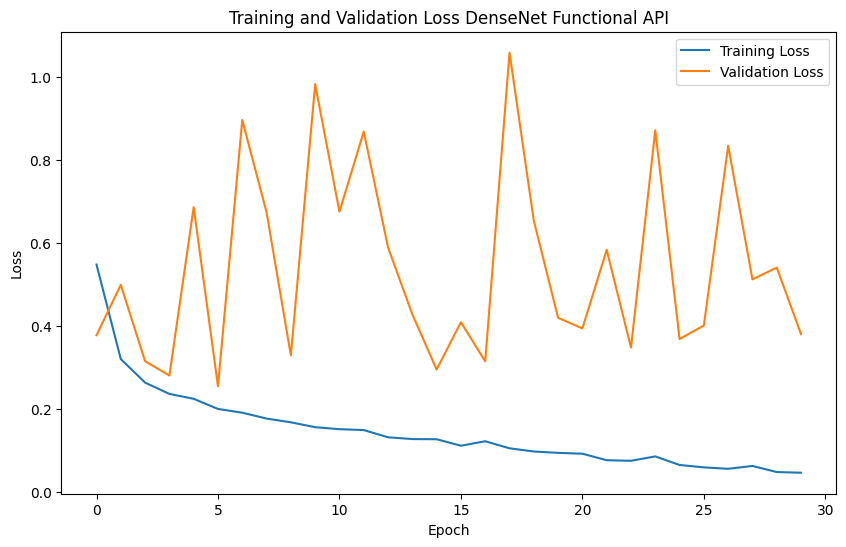

In [143]:
plotValidationGraph(denseFuncHist , 'DenseNet Functional API')

In [70]:
finalModelsDict['denseNetFinalFunctionAPIModel'] = denseNetFinalFunctionAPIModel

DenseNet - Using Gaussian Blur Sequential Model

In [57]:
denseNetFinalSequentialModel = tf.keras.Sequential([
    denseNetFastModel,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid') # adding dense layer with sigmoid activation for binary classification
])

denseNetFinalSequentialModel.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

denseSeqHist = denseNetFinalSequentialModel.fit(
    fastTrainDataBlur,
    epochs=15,  
    validation_data=fastTestGenerator, # faster test data
    verbose = 1 # used to show validation values during training
)

Epoch 1/15
283/283 [==============================] - 52s 147ms/step - loss: 0.0522 - accuracy: 0.9831 - val_loss: 0.8664 - val_accuracy: 0.7733
Epoch 2/15
283/283 [==============================] - 40s 142ms/step - loss: 0.0259 - accuracy: 0.9907 - val_loss: 0.6389 - val_accuracy: 0.8600
Epoch 3/15
283/283 [==============================] - 40s 142ms/step - loss: 0.0204 - accuracy: 0.9930 - val_loss: 0.6023 - val_accuracy: 0.8684
Epoch 4/15
283/283 [==============================] - 40s 142ms/step - loss: 0.0195 - accuracy: 0.9940 - val_loss: 0.5061 - val_accuracy: 0.8897
Epoch 5/15
283/283 [==============================] - 40s 142ms/step - loss: 0.0214 - accuracy: 0.9926 - val_loss: 0.9448 - val_accuracy: 0.8480
Epoch 6/15
283/283 [==============================] - 40s 142ms/step - loss: 0.0181 - accuracy: 0.9935 - val_loss: 0.9335 - val_accuracy: 0.8283
Epoch 7/15
283/283 [==============================] - 40s 142ms/step - loss: 0.0086 - accuracy: 0.9970 - val_loss: 1.1474 - val_ac

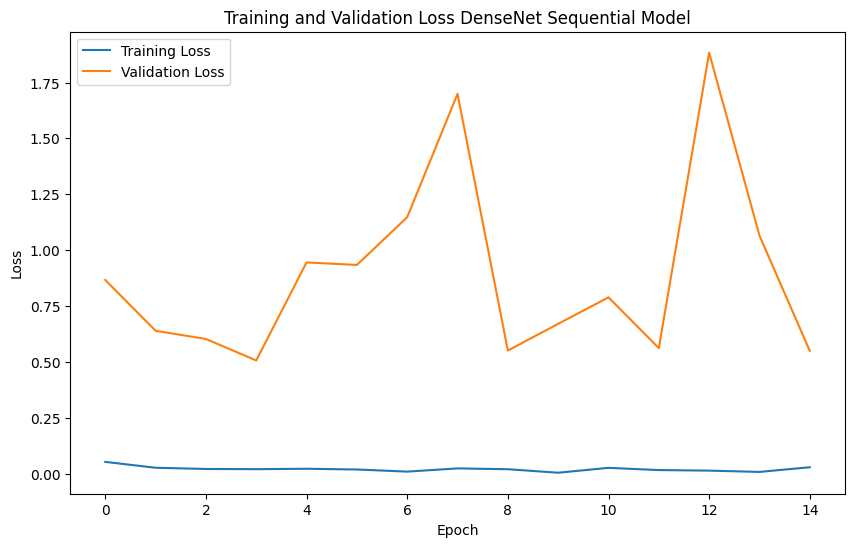

In [144]:
plotValidationGraph(denseSeqHist , 'DenseNet Sequential Model')

In [71]:
finalModelsDict['denseNetFinalSequentialModel'] = denseNetFinalSequentialModel

MobileNet - Using Gaussian Blur , shuffle , imageNet functional API Model

In [63]:
MobileNetFunctionModelImagenetWeights = MobileNetV2(
    input_shape=finalInputShape,
    include_top=False,
    weights='imagenet'
)

mobileNetFinalFunctionalAPIModel = createMobileModelFunctionalAPI(MobileNetFunctionModelImagenetWeights)

mobileNetFinalFunctionalAPIModel.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
mobileFuncHist = mobileNetFinalFunctionalAPIModel.fit(
    fastTrainDataShuffleHF,
    epochs=finalEpochs,
    validation_data=fastTestGenerator,
    batch_size=64,
    verbose = 1
)


Epoch 1/30
283/283 [==============================] - 48s 90ms/step - loss: 0.2546 - accuracy: 0.9075 - val_loss: 1.3346 - val_accuracy: 0.6253
Epoch 2/30
283/283 [==============================] - 25s 88ms/step - loss: 0.1782 - accuracy: 0.9336 - val_loss: 1.4881 - val_accuracy: 0.6379
Epoch 3/30
283/283 [==============================] - 25s 88ms/step - loss: 0.1527 - accuracy: 0.9418 - val_loss: 1.6761 - val_accuracy: 0.7035
Epoch 4/30
283/283 [==============================] - 25s 89ms/step - loss: 0.1420 - accuracy: 0.9468 - val_loss: 3.1170 - val_accuracy: 0.4270
Epoch 5/30
283/283 [==============================] - 25s 88ms/step - loss: 0.1535 - accuracy: 0.9429 - val_loss: 3.8565 - val_accuracy: 0.5517
Epoch 6/30
283/283 [==============================] - 25s 90ms/step - loss: 0.1304 - accuracy: 0.9501 - val_loss: 4.2464 - val_accuracy: 0.5214
Epoch 7/30
283/283 [==============================] - 25s 89ms/step - loss: 0.1124 - accuracy: 0.9577 - val_loss: 0.8090 - val_accuracy:

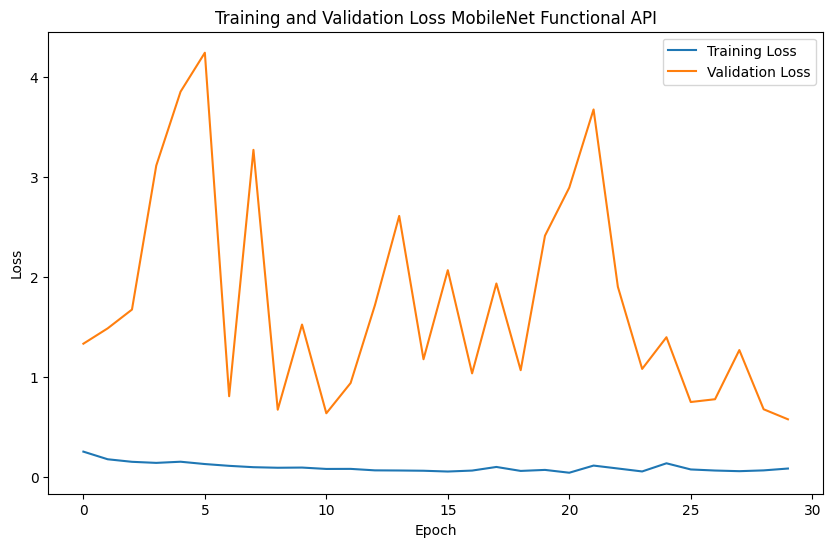

In [145]:
plotValidationGraph(mobileFuncHist ,'MobileNet Functional API')

In [72]:
finalModelsDict['mobileNetFinalFunctionalAPIModel'] = mobileNetFinalFunctionalAPIModel

MobileNet - Using Gaussian Blur , shuffle Sequential Model

In [58]:
mobileNetFinalSequentialModel = tf.keras.Sequential([
    mobileNetSlowModel,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])
mobileNetFinalSequentialModel.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
mobileSenqHist = mobileNetFinalSequentialModel.fit(
    slowTrainDataShuffleBlur,
    epochs=15,
    validation_data=slowTestGenerator,
    verbose = 1
)

Epoch 1/15
565/565 [==============================] - 82s 138ms/step - loss: 0.0441 - accuracy: 0.9836 - val_loss: 1.7823 - val_accuracy: 0.6980
Epoch 2/15
565/565 [==============================] - 77s 137ms/step - loss: 0.0380 - accuracy: 0.9865 - val_loss: 0.9246 - val_accuracy: 0.8130
Epoch 3/15
565/565 [==============================] - 77s 137ms/step - loss: 0.0283 - accuracy: 0.9906 - val_loss: 1.3446 - val_accuracy: 0.7602
Epoch 4/15
565/565 [==============================] - 77s 136ms/step - loss: 0.0218 - accuracy: 0.9926 - val_loss: 1.9623 - val_accuracy: 0.7049
Epoch 5/15
565/565 [==============================] - 77s 137ms/step - loss: 0.0472 - accuracy: 0.9835 - val_loss: 0.4606 - val_accuracy: 0.9043
Epoch 6/15
565/565 [==============================] - 77s 137ms/step - loss: 0.0186 - accuracy: 0.9934 - val_loss: 0.8060 - val_accuracy: 0.8624
Epoch 7/15
565/565 [==============================] - 77s 137ms/step - loss: 0.0177 - accuracy: 0.9936 - val_loss: 0.5607 - val_ac

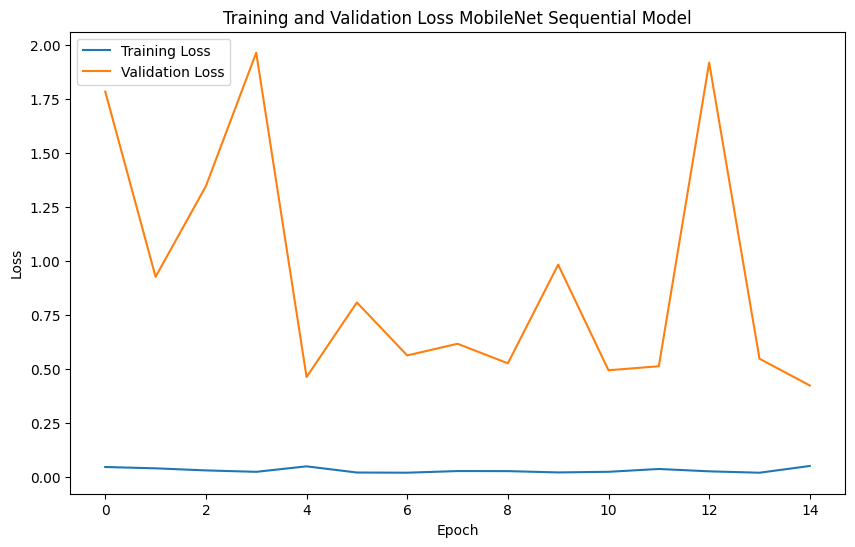

In [146]:
plotValidationGraph(mobileSenqHist ,'MobileNet Sequential Model')

In [73]:
finalModelsDict['mobileNetFinalSequentialModel'] = mobileNetFinalSequentialModel

ResNet18 - Using Horizontal flip , shuffle functional API Model

In [55]:
finalResNetModelSlow  = ResNet18(slowInputShape, numClasses)

finalResNetModelSlow.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

finalResSlowHist = finalResNetModelSlow.fit(
    slowTrainDataShuffleHF,
    epochs = finalEpochs,
    validation_data=slowTestGenerator,
    verbose = 1
)

Epoch 1/30
565/565 [==============================] - 41s 69ms/step - loss: 0.4430 - accuracy: 0.8170 - val_loss: 0.4439 - val_accuracy: 0.8433
Epoch 2/30
565/565 [==============================] - 39s 69ms/step - loss: 0.3714 - accuracy: 0.8447 - val_loss: 0.6022 - val_accuracy: 0.6947
Epoch 3/30
565/565 [==============================] - 39s 69ms/step - loss: 0.3454 - accuracy: 0.8584 - val_loss: 0.4035 - val_accuracy: 0.8456
Epoch 4/30
565/565 [==============================] - 39s 69ms/step - loss: 0.3313 - accuracy: 0.8632 - val_loss: 0.4951 - val_accuracy: 0.7986
Epoch 5/30
565/565 [==============================] - 39s 70ms/step - loss: 0.3137 - accuracy: 0.8732 - val_loss: 0.4339 - val_accuracy: 0.7831
Epoch 6/30
565/565 [==============================] - 40s 71ms/step - loss: 0.3036 - accuracy: 0.8758 - val_loss: 0.4124 - val_accuracy: 0.8179
Epoch 7/30
565/565 [==============================] - 39s 69ms/step - loss: 0.2932 - accuracy: 0.8784 - val_loss: 0.6195 - val_accuracy:

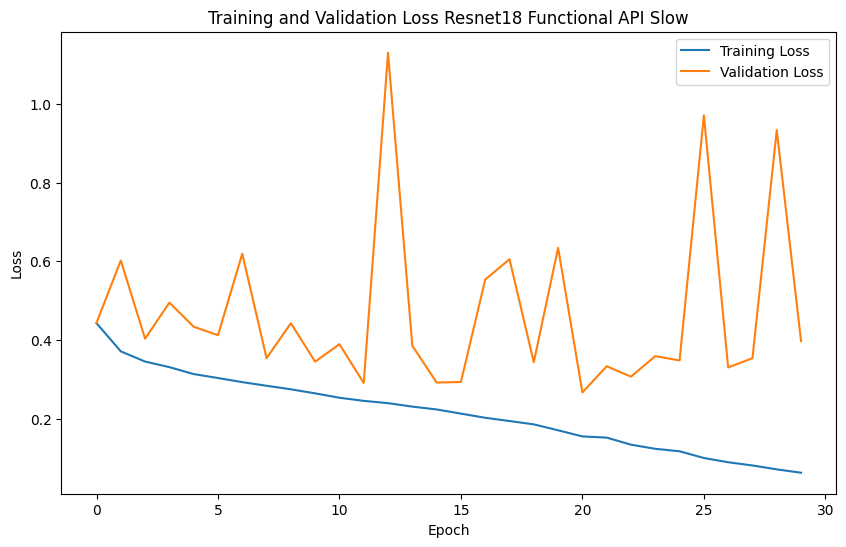

In [147]:
plotValidationGraph(finalResSlowHist ,'Resnet18 Functional API Slow')

In [74]:
finalModelsDict['finalResNetModelSlow'] = finalResNetModelSlow

In [59]:
finalResNetModelFast= ResNet18(fastInputShape, numClasses)

finalResNetModelFast.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

finalResFastHist = finalResNetModelFast.fit(
    fastTrainDataHF,
    epochs=15,
    validation_data=fastTestGenerator,
    verbose = 1
)

Epoch 1/15
283/283 [==============================] - 21s 67ms/step - loss: 0.4272 - accuracy: 0.8220 - val_loss: 0.4067 - val_accuracy: 0.8331
Epoch 2/15
283/283 [==============================] - 18s 65ms/step - loss: 0.3652 - accuracy: 0.8441 - val_loss: 0.3708 - val_accuracy: 0.8429
Epoch 3/15
283/283 [==============================] - 18s 65ms/step - loss: 0.3378 - accuracy: 0.8627 - val_loss: 0.3751 - val_accuracy: 0.8620
Epoch 4/15
283/283 [==============================] - 19s 66ms/step - loss: 0.3214 - accuracy: 0.8698 - val_loss: 0.3389 - val_accuracy: 0.8620
Epoch 5/15
283/283 [==============================] - 18s 65ms/step - loss: 0.3073 - accuracy: 0.8733 - val_loss: 0.4313 - val_accuracy: 0.8161
Epoch 6/15
283/283 [==============================] - 18s 65ms/step - loss: 0.2963 - accuracy: 0.8790 - val_loss: 0.3323 - val_accuracy: 0.8560
Epoch 7/15
283/283 [==============================] - 18s 65ms/step - loss: 0.2811 - accuracy: 0.8849 - val_loss: 0.4593 - val_accuracy:

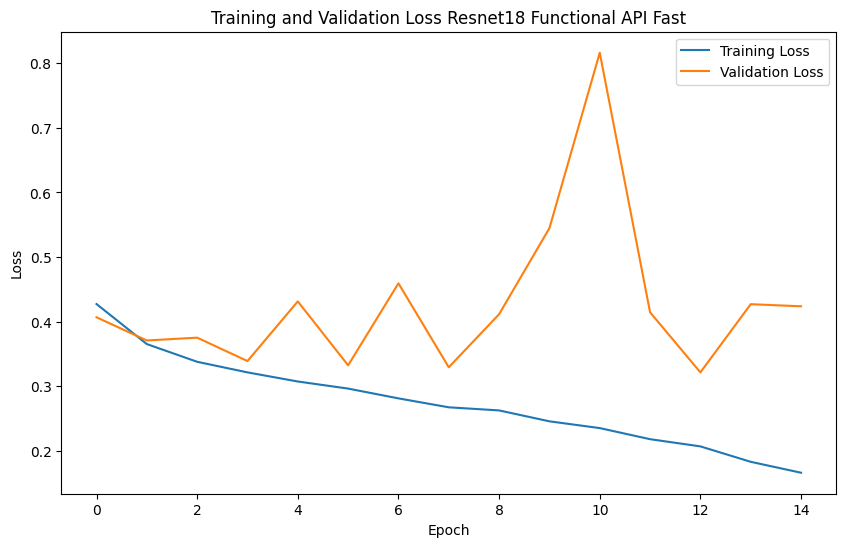

In [148]:
plotValidationGraph(finalResFastHist ,'Resnet18 Functional API Fast')

In [108]:
finalModelsDict['finalResNetModelFast'] = finalResNetModelFast

In [109]:
finalModelsDataFrame = evaluateFunctionalModels(finalModelsDict,slowTestGenerator,fastTestGenerator)

In [110]:
finalModelsDataFrame

,Model Name,Accuracy,Precision,Recall,F1-Score
0,denseNetFinalFunctionAPIModel,0.887436,0.892728,0.887436,0.887896
0,denseNetFinalSequentialModel,0.868380,0.879699,0.868380,0.868934
0,mobileNetFinalFunctionalAPIModel,0.892533,0.895867,0.892533,0.892917
0,mobileNetFinalSequentialModel,0.838023,0.849782,0.838023,0.833777
0,finalResNetModelSlow,0.884777,0.885591,0.884777,0.884982
0,finalResNetModelFast,0.827388,0.827440,0.827388,0.827413


In [111]:
finalModelsDataFrame.sort_values(by= 'F1-Score', ascending = False)

,Model Name,Accuracy,Precision,Recall,F1-Score
0,mobileNetFinalFunctionalAPIModel,0.892533,0.895867,0.892533,0.892917
0,denseNetFinalFunctionAPIModel,0.887436,0.892728,0.887436,0.887896
0,finalResNetModelSlow,0.884777,0.885591,0.884777,0.884982
0,denseNetFinalSequentialModel,0.868380,0.879699,0.868380,0.868934
0,mobileNetFinalSequentialModel,0.838023,0.849782,0.838023,0.833777
0,finalResNetModelFast,0.827388,0.827440,0.827388,0.827413


In [174]:
# the below function plots confusion matrix when called
# modelName and array of confusion matrix is passed as parameter

def plotConfusionMatrix(modelName , confArray):

    display = ConfusionMatrixDisplay(confusion_matrix = confArray , display_labels = ['Organic','Recyclable'])
    print(modelName)
    display.plot()
    plt.show()

In [175]:
# below function take a dictionary of models searches for key words and creates confsuion matrices

def createConfusionMatrices(modelDictionary , slowData, fastData):
    
    for modelName , model in modelDictionary.items():
       
        if 'dense' in modelName.lower():
            predictions = model.predict(fastData)

            # used to convert values larger then 0.5 to 1 
            predictedLabels = (predictions > 0.5).astype(int)
            
            trueLabels = fastData.classes

            # Generate the confusion matrix
            confusionMat = confusion_matrix(trueLabels, predictedLabels)
            
            plotConfusionMatrix(modelName,confusionMat)
            
        elif 'res' and 'fast' in modelName.lower():

            predictions = model.predict(fastData)

            # used to convert values larger then 0.5 to 1 
            predictedLabels = (predictions > 0.5).astype(int)
            
            trueLabels = fastData.classes

            # Generate the confusion matrix
            confusionMat = confusion_matrix(trueLabels, predictedLabels)
            
            plotConfusionMatrix(modelName,confusionMat)
            
        elif 'res' and 'slow' in modelName.lower():
        
            predictions = model.predict(slowData)

            # used to convert values larger then 0.5 to 1 
            predictedLabels = (predictions > 0.5).astype(int)
            
            trueLabels = slowData.classes

            # Generate the confusion matrix
            confusionMat = confusion_matrix(trueLabels, predictedLabels)
            
            plotConfusionMatrix(modelName,confusionMat)
            
        elif 'mobile' and 'seq' in modelName.lower():
        
            predictions = model.predict(slowData)

            # used to convert values larger then 0.5 to 1 
            predictedLabels = (predictions > 0.5).astype(int)
            
            trueLabels = slowData.classes

            # Generate the confusion matrix
            confusionMat = confusion_matrix(trueLabels, predictedLabels)

            plotConfusionMatrix(modelName,confusionMat)
            
        elif 'mobile' and 'func' in modelName.lower():
        
            predictions = model.predict(fastData)

            # used to convert values larger then 0.5 to 1 
            predictedLabels = (predictions > 0.5).astype(int)
            
            trueLabels = fastData.classes

            # Generate the confusion matrix
            confusionMat = confusion_matrix(trueLabels, predictedLabels)

            plotConfusionMatrix(modelName,confusionMat)
           

denseNetFinalFunctionAPIModel


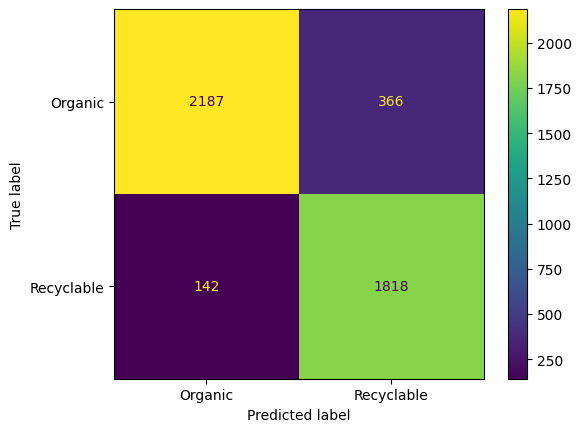

denseNetFinalSequentialModel


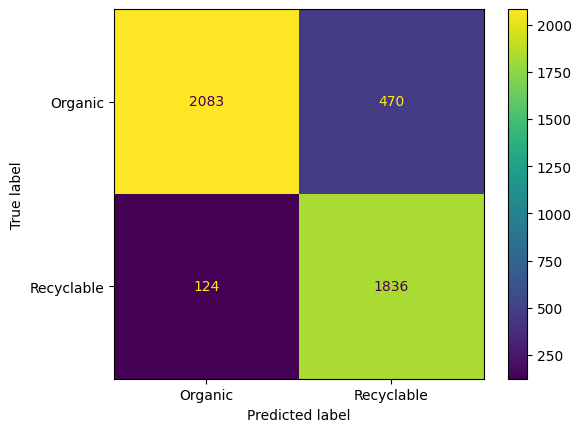

mobileNetFinalFunctionalAPIModel


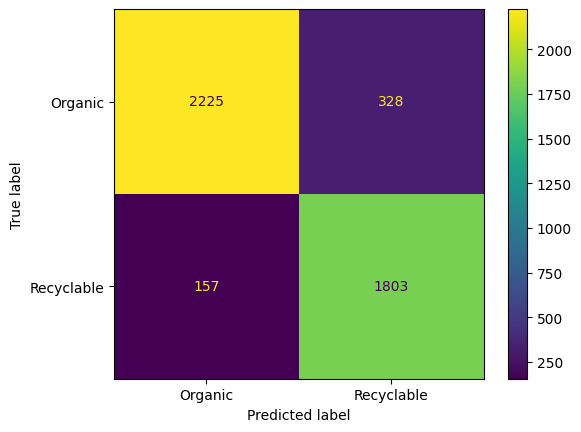

mobileNetFinalSequentialModel


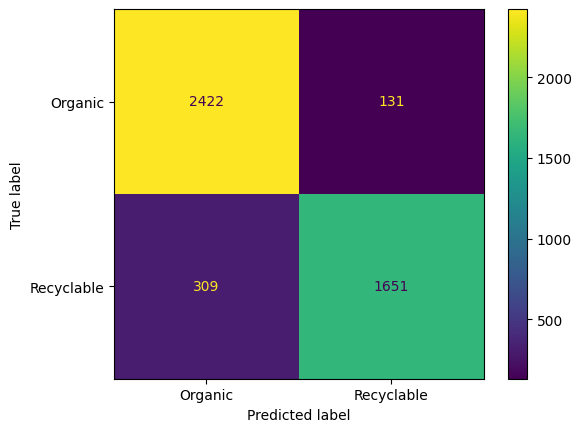

finalResNetModelSlow


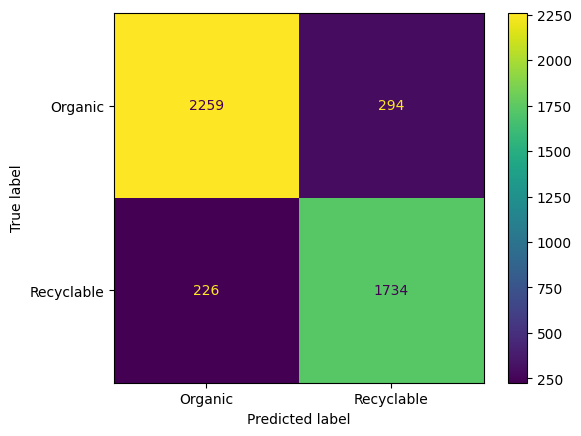

finalResNetModelFast


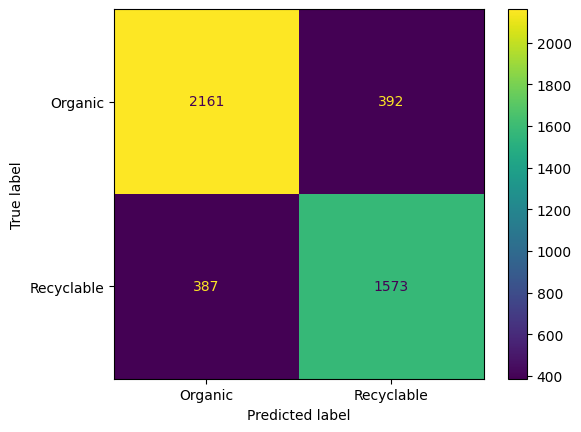

In [176]:
createConfusionMatrices(finalModelsDict, slowTestGenerator,fastTestGenerator)